# Preventing Vehicle Insurance Fraud with ML

![Logo](/work/Fraud-Investigation.jpg)

# Background & Objective

Vehicle insurance fraud is a significant issue for the insurance industry, causing considerable financial losses and reputational damage. This illegal activity involves fraudulent and exaggerated claims related to property damage or personal injuries from accidents. There are various forms of such deception, ranging from staged accidents, where fraudsters deliberately arrange collisions, to the use of phantom passengers, individuals who falsely claim they suffered injuries in accidents where they were not present.

This fraudulent activity is not only a financial burden, but it also imposes extra costs on honest policyholders, as insurance companies often raise premiums to cover their losses. Thus, effective detection and prevention of insurance fraud are vital to maintaining a healthy and fair insurance market.

Objectives

Predictive Model Development: Leverage advanced machine learning techniques to design a predictive model for identifying potential fraudulent vehicle insurance claims. This model will analyze a dataset of vehicle attributes, model, accident details, and policy details to flag suspicious activities for further investigation, thereby reducing financial and reputational risks.

Pattern Recognition and Risk Profiling: Uncover patterns or key characteristics associated with fraudulent activities. With these insights, establish risk profiles for various types of transactions or customers. This output will enhance risk management strategies and contribute to the prevention of fraudulent activities in the future.

# Executive Summary

This report presents a comprehensive analysis of vehicle insurance fraud and introduces a predictive model designed to detect potential fraudulent claims. The study utilizes advanced machine learning techniques, with the Random Forest Classifier proving to be the most effective model.

The performance of the Random Forest Classifier was assessed using ROC-AUC scores and F1-scores as the primary evaluation metrics. The results underscore its high effectiveness, achieving an F1-score of 0.82 for class 1 (fraudulent claims). This score indicates a high sensitivity towards identifying fraudulent instances, thereby helping to minimize false negatives that could lead to financial losses for the insurance company. The ROC-AUC score of 0.792 demonstrates the model's robust ability to differentiate between fraudulent and non-fraudulent claims.

Furthermore, the report highlights the importance of various features in predicting fraudulent claims. According to the Random Forest Classifier, factors such as Claim Fault, Base Policy Type, and Total Claim Lag (measured in days) hold significant importance, indicating their substantial impact on the model's predictions.

The implementation of the Random Forest Classifier could yield significant savings for the business by reducing the occurrence of fraudulent claims. Given the classification model's ability to predict fraudulent claims nearly 80% of the time, the potential savings could amount to approximately $1,340,000 over the next 12 months.

In conclusion, the application of the Random Forest Classifier can effectively counter fraudulent activities in vehicle insurance, leading to substantial cost savings and enhanced operational efficiency. This model shows promising results in accurately predicting fraudulent claims, thereby enabling proactive measures to effectively mitigate risks.

# Extract, Transform, and Load Tables

Source (data has been modified): https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection

<div style="width: 640px; height: 480px; margin: 10px; position: relative;"><iframe allowfullscreen frameborder="0" style="width:640px; height:480px" src="https://lucid.app/documents/embedded/2a0d0023-5a12-420d-8e9c-fb3d5e1d0013" id="LS37-PrqlNff"></iframe></div>

## Connecting to SQLite Database

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sqlite3
import calendar
import os
import warnings
warnings.filterwarnings('ignore')
import time

plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (15, 6)
sns.set_style('white')

seed = 9507
np.random.seed(seed)

In [ ]:
sql_db_connection = sqlite3.connect("/work/Integrity_Insurance_Solutions.db")

query = "SELECT * FROM claims_analysis_view"
df = pd.read_sql(query, sql_db_connection,parse_dates=['Accident_Date', 'Claim_Date'])

sql_db_connection.close()

df.head(5)

,ClaimID,CustomerID,PolicyNumber,VehicleID,Accident_Date,Claim_Date,AccidentArea,Fault,RepNumber,AgentType,...,Deductible,PastNumberOfClaims,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,VehicleCategory,BasePolicyType,Make,VehiclePrice,AgeOfVehicle
0,7965,14049,1,4831,2019-12-28,2020-01-03,Urban,Policy Holder,12,External,...,300,none,none,1 year,3 to 4,Sport,Liability,Honda,more than 69000,3 years
1,10715,14167,2,924,2019-01-12,2019-01-24,Urban,Policy Holder,15,External,...,400,none,none,no change,1 vehicle,Sport,Collision,Honda,more than 69000,6 years
2,11247,8427,3,11403,2019-10-28,2019-11-17,Urban,Policy Holder,7,External,...,400,1,none,no change,1 vehicle,Sport,Collision,Honda,more than 69000,7 years
3,11040,14091,4,1891,2019-06-11,2019-07-08,Rural,Third Party,4,External,...,400,1,more than 5,no change,1 vehicle,Sedan,Liability,Toyota,20000 to 29000,more than 7
4,10754,11837,5,2394,2019-01-24,2019-02-15,Urban,Third Party,3,External,...,400,none,none,no change,1 vehicle,Sport,Collision,Honda,more than 69000,5 years


In [ ]:
df.shape

(15420, 30)

# Data Cleansing & Verification

### Data Dictionary & Assumptions

- **Accident_Date**: The date when the accident occurred.
- **Claim_Date**: The date when the claim was submitted.
- **AccidentArea**: The area where the accident occurred (Urban/Rural).
- **Fault**: Who was at fault in the accident (Policy Holder/Third Party).
- **Days_Policy_Accident**: The number of days between the policy start date and the accident.
- **Days_Policy_Claim**: The number of days between the policy start date and the claim.
- **PoliceReportFiled**: Whether a police report was filed (1) or not (0).
- **WitnessPresent**: Whether a witness was present during the accident (1) or not (0).
- **FraudFound_P**: Indicates whether the claim was fraudulent (1) or not (0). This variable serves as the target variable for modelling purposes.
- **Sex**: The gender of the policy holder.
- **MaritalStatus**: The marital status of the policy holder.
- **Age**: The age of the individual making claim. Minimum age of individual on policy is 16 years old. Dropped missing values
- **DriverRating**: The driving rating of the policy holder. Assumption: Poor(1), Fair(2), Good(3) and Excellent(4)
- **Age_Bin**: The age bin of the policy holder.
- **Deductible**: The deductible on the policy.
- **PastNumberOfClaims**: The number of past claims made by the policy holder.
- **NumberOfSuppliments**: The number of supplements on the policy.
- **AddressChange_Claim**: Represents the duration in years since the address on the policy was last modified.
- **NumberOfCars**: The number of cars covered on the policy.
- **VehicleCategory**: The category of the vehicle covered under the policy.
- **BasePolicyType**: The base type of the policy.
- **Make**: The make of the vehicle.
- **VehiclePrice**: The price range of the vehicle.
- **AgeOfVehicle**: The age range of the vehicle.
- **Claim_Lag_Days**: The number of days between the accident occurring and the claim being submitted.

In [ ]:
# Understanding the current features in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ClaimID               15420 non-null  int64         
 1   CustomerID            15420 non-null  int64         
 2   PolicyNumber          15420 non-null  int64         
 3   VehicleID             15420 non-null  int64         
 4   Accident_Date         15419 non-null  datetime64[ns]
 5   Claim_Date            15419 non-null  datetime64[ns]
 6   AccidentArea          15420 non-null  object        
 7   Fault                 15420 non-null  object        
 8   RepNumber             15420 non-null  int64         
 9   AgentType             15420 non-null  object        
 10  Days_Policy_Accident  15420 non-null  object        
 11  Days_Policy_Claim     15420 non-null  object        
 12  PoliceReportFiled     15420 non-null  int64         
 13  WitnessPresent  

In [ ]:
# Count the number of missing values in each column
print(df.isnull().sum())

ClaimID                 0
CustomerID              0
PolicyNumber            0
VehicleID               0
Accident_Date           1
Claim_Date              1
AccidentArea            0
Fault                   0
RepNumber               0
AgentType               0
Days_Policy_Accident    0
Days_Policy_Claim       0
PoliceReportFiled       0
WitnessPresent          0
FraudFound_P            0
Sex                     0
MaritalStatus           0
Age                     0
DriverRating            0
Age_Bin                 0
Deductible              0
PastNumberOfClaims      0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
VehicleCategory         0
BasePolicyType          0
Make                    0
VehiclePrice            0
AgeOfVehicle            0
dtype: int64


In [ ]:
# Drop the rows with missing values in 'Accident_Date' and 'Claim_Date' columns
df.dropna(subset=['Accident_Date', 'Claim_Date'], inplace=True)

In [ ]:
# Validate the numerical variables
numerical = ['PoliceReportFiled','WitnessPresent','FraudFound_P','Age','DriverRating','Deductible']
df[numerical].describe()

,PoliceReportFiled,WitnessPresent,FraudFound_P,Age,DriverRating,Deductible
count,15419.000000,15419.000000,15419.000000,15419.000000,15419.000000,15419.000000
mean,0.027758,0.005642,0.059861,39.858292,2.487840,407.704780
std,0.164284,0.074906,0.237237,13.488996,1.119482,43.952379
min,0.000000,0.000000,0.000000,0.000000,1.000000,300.000000
25%,0.000000,0.000000,0.000000,31.000000,1.000000,400.000000
50%,0.000000,0.000000,0.000000,38.000000,2.000000,400.000000
75%,0.000000,0.000000,0.000000,48.000000,3.000000,400.000000
max,1.000000,1.000000,1.000000,80.000000,4.000000,700.000000


In [ ]:
# Count rows where 'Age' = 0
age_zero_count = df[df['Age'] == 0].shape[0]
age_zero_count

319

In [ ]:
# Remove rows where 'Age' = 0
df = df[df['Age'] != 0]
df[df['Age'] == 0].shape[0]

0

In [ ]:
# Validate the categorical variables
categorical = ['AccidentArea','Fault','Days_Policy_Accident','Days_Policy_Claim', 'Sex','MaritalStatus','DriverRating','Age_Bin'
,'PastNumberOfClaims', 'NumberOfSuppliments','AddressChange_Claim','NumberOfCars','VehicleCategory','BasePolicyType','Make','VehiclePrice','AgeOfVehicle','RepNumber','AgentType']

for c in categorical:
    print(df[c].value_counts())
    print()

Urban    13554
Rural     1546
Name: AccidentArea, dtype: int64

Policy Holder    10952
Third Party       4148
Name: Fault, dtype: int64

more than 30    14927
8 to 15            55
none               55
15 to 30           49
1 to 7             14
Name: Days_Policy_Accident, dtype: int64

more than 30    15023
15 to 30           56
8 to 15            21
Name: Days_Policy_Claim, dtype: int64

Male      12680
Female     2420
Name: Sex, dtype: int64

Married     10625
Single       4364
Divorced       76
Widow          35
Name: MaritalStatus, dtype: int64

1    3866
3    3788
4    3725
2    3721
Name: DriverRating, dtype: int64

50+      3568
30-34    2837
25-29    2291
35-39    2204
40-44    2022
45-49    1546
20-24     537
15-19      95
Name: Age_Bin, dtype: int64

2 to 4         5378
none           4243
1              3509
more than 4    1970
Name: PastNumberOfClaims, dtype: int64

none           6729
more than 5    3866
1 to 2         2489
3 to 5         2016
Name: NumberOfSuppliments, 

## Feature Engineering

In [ ]:
# Transform date columns into categorical month labels and extract the Year and Day of the Week values
df['Accident_Month'] = df['Accident_Date'].dt.month
df['Accident_Year'] = df['Accident_Date'].dt.year
df['Accident_DayOfWeek'] = df['Accident_Date'].dt.dayofweek

df['Claim_Month'] = df['Claim_Date'].dt.month
df['Claim_Year'] = df['Claim_Date'].dt.year
df['Claim_DayOfWeek'] = df['Claim_Date'].dt.dayofweek

# Convert 'Month' columns from numeric to string format (Jan, Feb, etc.)
df['Accident_Month'] = df['Accident_Month'].apply(lambda x: calendar.month_abbr[x])
df['Claim_Month'] = df['Claim_Month'].apply(lambda x: calendar.month_abbr[x])

# Define a dictionary to map the numeric day of the week to the string format
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

# Convert 'DayOfWeek' columns from numeric to string format
df['Accident_DayOfWeek'] = df['Accident_DayOfWeek'].map(dayOfWeek)
df['Claim_DayOfWeek'] = df['Claim_DayOfWeek'].map(dayOfWeek)

In [ ]:
print("Unique values in Accident_Month:", df['Accident_Month'].unique())
print("Unique values in Accident_Year:", df['Accident_Year'].unique())
print("Unique values in Accident_DayOfWeek:", df['Accident_DayOfWeek'].unique())
print("Unique values in Claim_Month:", df['Claim_Month'].unique())
print("Unique values in Claim_Year:", df['Claim_Year'].unique())
print("Unique values in Claim_DayOfWeek:", df['Claim_DayOfWeek'].unique())


Unique values in Accident_Month: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep' 'Nov']
Unique values in Accident_Year: [2019 2020 2021]
Unique values in Accident_DayOfWeek: ['Saturday' 'Monday' 'Tuesday' 'Thursday' 'Friday' 'Wednesday' 'Sunday']
Unique values in Claim_Month: ['Jan' 'Nov' 'Jul' 'Feb' 'Dec' 'Apr' 'Mar' 'Aug' 'May' 'Jun' 'Sep' 'Oct']
Unique values in Claim_Year: [2020 2019 2021 2022]
Unique values in Claim_DayOfWeek: ['Friday' 'Thursday' 'Sunday' 'Monday' 'Saturday' 'Tuesday' 'Wednesday']


In [ ]:
# Create 'Claim_Lag_Days' column as the difference between 'Claim_Date' and 'Accident_Date'
df['Claim_Lag_Days'] = (df['Claim_Date'] - df['Accident_Date']).dt.days

# Exploratory Data Analysis

## Is the Dataset Balanced?

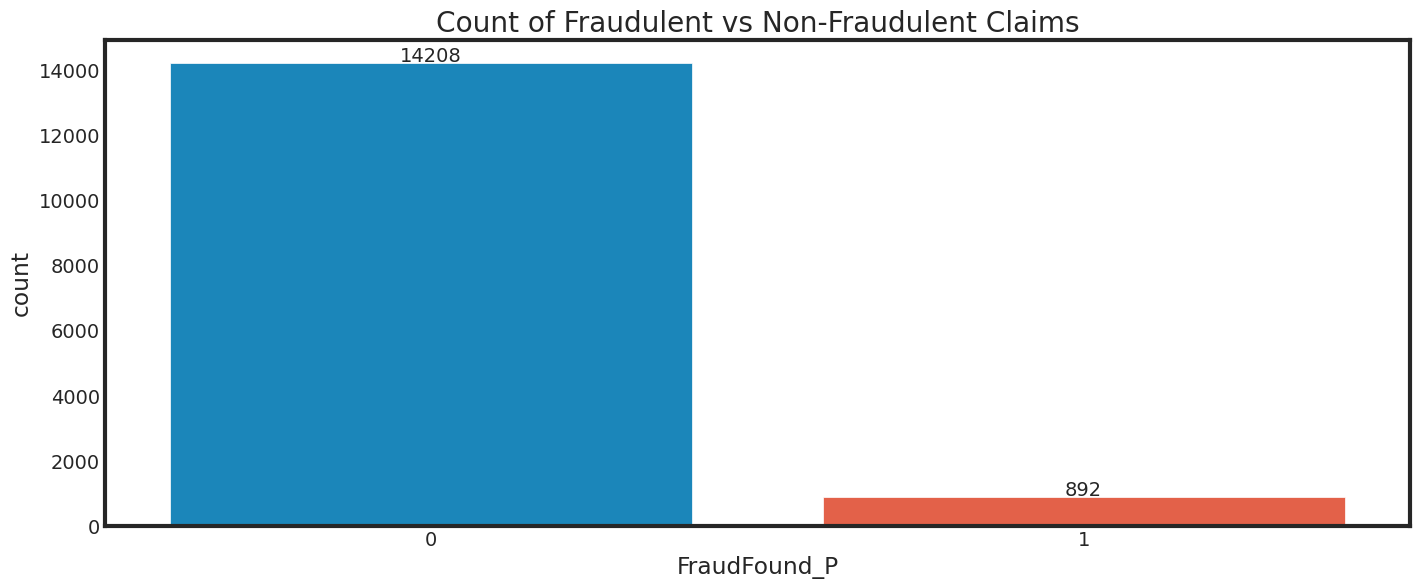

In [ ]:
ax = sns.countplot(x='FraudFound_P', data=df)
plt.title('Count of Fraudulent vs Non-Fraudulent Claims')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [ ]:
print('The number of Non-Frauds are: ' + str(df['FraudFound_P'].value_counts()[0]) + ' which is ', round(df['FraudFound_P'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(df['FraudFound_P'].value_counts()[1]) + ' which is ', round(df['FraudFound_P'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

The number of Non-Frauds are: 14208 which is  94.09 % of the dataset
The number of Frauds are: 892 which is  5.91 % of the dataset


The visualisation above reveals a significant imbalance in the insurance claims data, with non-fraudulent claims vastly outnumbering fraudulent ones. Fraudulent claims make up **892** or **5.91%** of the total data set. This highlights a common challenge in fraud detection, where the minority class (fraudulent claims) is often the most critical to identify accurately. This imbalance will need to be carefully addressed during the model building process to ensure the development of a robust and reliable fraud detection method

## Fraudulent Claims: Is There a Growing Concern?

In [ ]:
# Calculate total fraudulent cases and total cases for each year
fraud_cases_by_year = df.groupby('Accident_Year')['FraudFound_P'].sum().reset_index()
total_cases_by_year = df.groupby('Accident_Year')['FraudFound_P'].count().reset_index()

# Merge these two dataframes on 'Accident_Year'
fraud_ratio_by_year = pd.merge(fraud_cases_by_year, total_cases_by_year, on='Accident_Year')
fraud_ratio_by_year.columns = ['Accident_Year', 'Total_Fraudulent_Cases', 'Total_Cases']

# Calculate the number of fraudulent cases per 1000 claims
fraud_ratio_by_year['Fraud_Per_1000_Claims'] = (fraud_ratio_by_year['Total_Fraudulent_Cases'] / fraud_ratio_by_year['Total_Cases']) * 1000


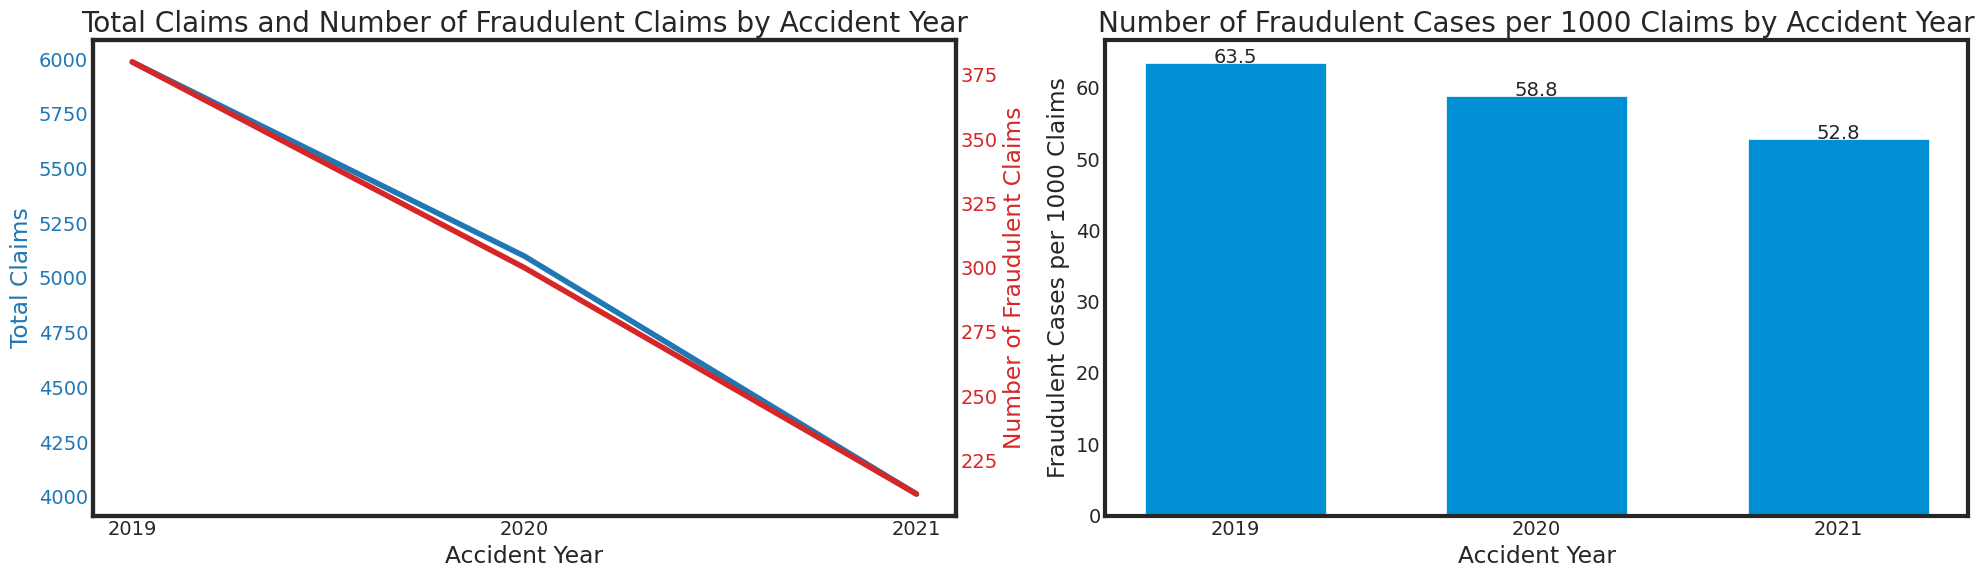

In [ ]:
fig, (ax1, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting total claims per year
ax1.set_xlabel('Accident Year')
ax1.set_ylabel('Total Claims', color='tab:blue')
ax1.plot(total_cases_by_year['Accident_Year'].astype(str), total_cases_by_year['FraudFound_P'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plotting fraudulent claims per year
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Fraudulent Claims', color='tab:red')
ax2.plot(fraud_cases_by_year['Accident_Year'].astype(str), fraud_cases_by_year['FraudFound_P'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Total Claims and Number of Fraudulent Claims by Accident Year')

# Bar plot for Number of Fraudulent Cases per 1000 Claims by Accident Year
ax3.bar(fraud_ratio_by_year['Accident_Year'].astype(str), fraud_ratio_by_year['Fraud_Per_1000_Claims'], width=0.6)
ax3.set_title('Number of Fraudulent Cases per 1000 Claims by Accident Year')
ax3.set_xlabel('Accident Year')
ax3.set_ylabel('Fraudulent Cases per 1000 Claims')

for i in range(len(fraud_ratio_by_year)):
    ax3.text(i, fraud_ratio_by_year['Fraud_Per_1000_Claims'].iloc[i], str(round(fraud_ratio_by_year['Fraud_Per_1000_Claims'].iloc[i], 1)), ha = 'center')

fig.tight_layout()
plt.show()


The frequency of fraudulent claims to total claims has continued to decline over the past three years. In 2019, about 63.5 fraudulent claims were made per 1000 claims, which decreased to approximately 58.8 in 2020. This downward trend continued into 2021, with the rate falling further to around 52.8 fraudulent claims per 1000. This indicates an ongoing improvement in the situation, as the rate of fraudulent claims is steadily decreasing each year.

In [ ]:
df['Accident_Date'] = pd.to_datetime(df['Accident_Date'])
df['Accident_Month_Year'] = df['Accident_Date'].dt.to_period('M')

# Calculate total fraudulent cases and total cases for each month-year
fraud_cases_by_month_year = df.groupby('Accident_Month_Year')['FraudFound_P'].sum().reset_index()
total_cases_by_month_year = df.groupby('Accident_Month_Year')['FraudFound_P'].count().reset_index()

fraud_ratio_by_month_year = pd.merge(fraud_cases_by_month_year, total_cases_by_month_year, on='Accident_Month_Year')
fraud_ratio_by_month_year.columns = ['Accident_Month_Year', 'Total_Fraudulent_Cases', 'Total_Cases']

# Calculate the number of fraudulent cases per 1000 claims
fraud_ratio_by_month_year['Fraud_Per_1000_Claims'] = (fraud_ratio_by_month_year['Total_Fraudulent_Cases'] / fraud_ratio_by_month_year['Total_Cases']) * 1000

fraud_ratio_by_month_year['Year'] = fraud_ratio_by_month_year['Accident_Month_Year'].dt.year

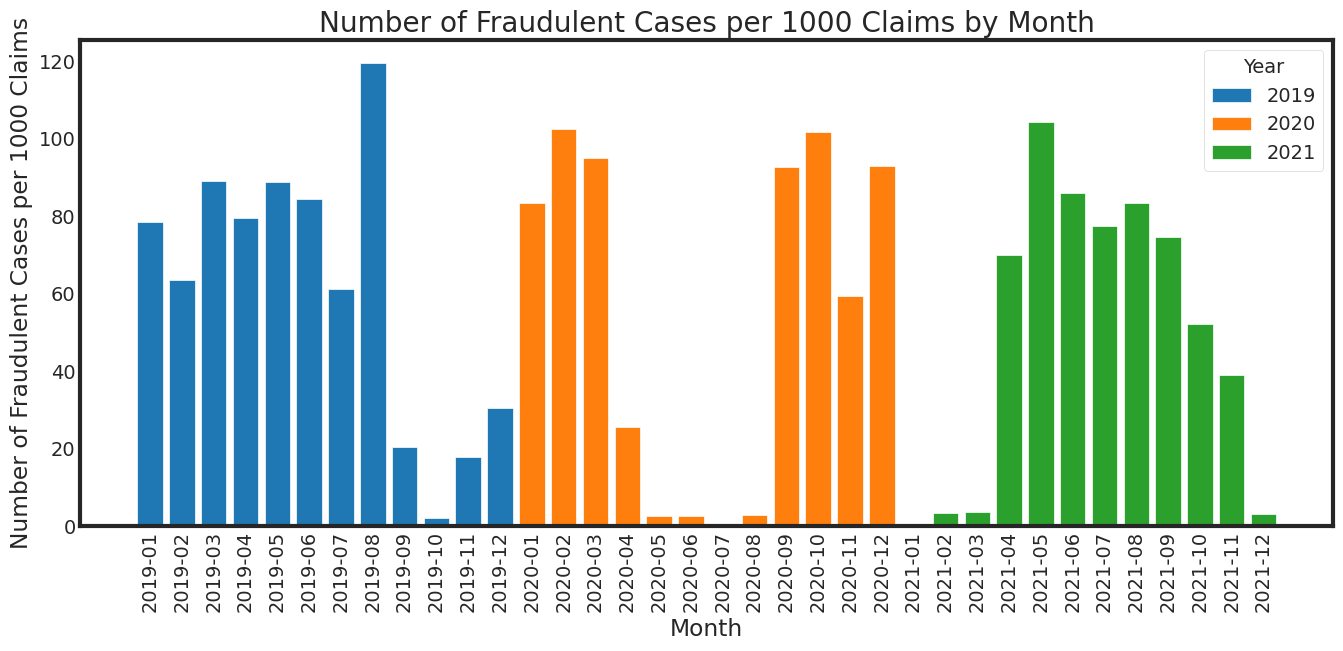

In [ ]:
plt.figure(figsize=(len(fraud_ratio_by_month_year) * 0.4, 6))

color_map = cm.get_cmap('tab10')
num_years = len(fraud_ratio_by_month_year['Year'].unique())

for  i, year in enumerate(fraud_ratio_by_month_year['Year'].unique()):
    data = fraud_ratio_by_month_year[fraud_ratio_by_month_year['Year'] == year]
    data['Fraud_Per_1000_Claims'] = pd.to_numeric(data['Fraud_Per_1000_Claims'])
    plt.bar(data['Accident_Month_Year'].astype(str), data['Fraud_Per_1000_Claims'], color=color_map(i % num_years), label=str(year))

plt.title('Number of Fraudulent Cases per 1000 Claims by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Cases per 1000 Claims')
plt.xticks(rotation=90)
plt.legend(title='Year')

plt.show()


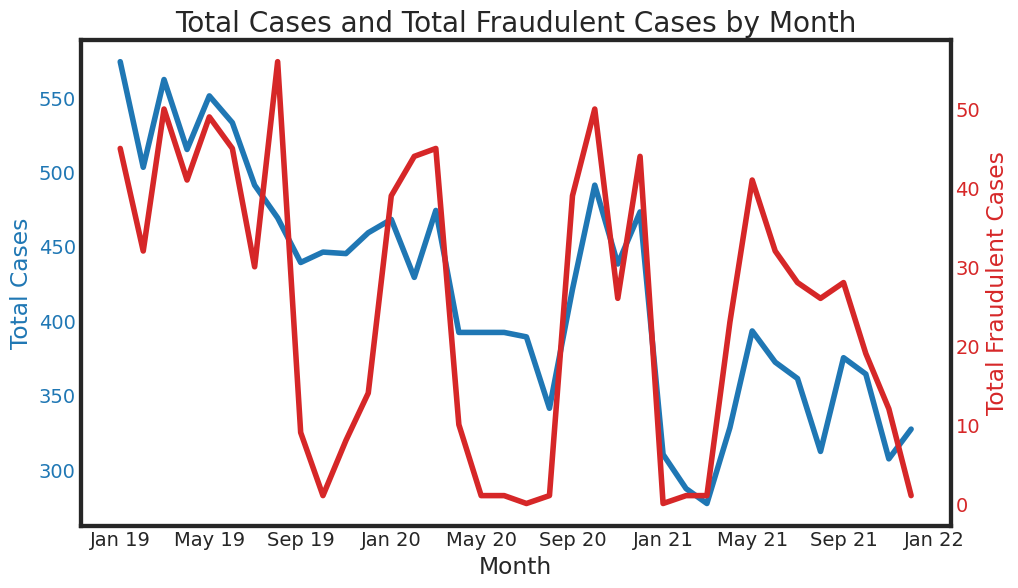

In [ ]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert 'Accident_Month_Year' from Period to datetime
fraud_ratio_by_month_year['Accident_Month_Year'] = pd.to_datetime(fraud_ratio_by_month_year['Accident_Month_Year'].astype(str))

# Plotting total claims per month-year
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Cases', color='tab:blue')
ax1.plot(fraud_ratio_by_month_year['Accident_Month_Year'], fraud_ratio_by_month_year['Total_Cases'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plotting total fraudulent cases per month-year
ax2 = ax1.twinx()
ax2.set_ylabel('Total Fraudulent Cases', color='tab:red')
ax2.plot(fraud_ratio_by_month_year['Accident_Month_Year'], fraud_ratio_by_month_year['Total_Fraudulent_Cases'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

date_format = mdates.DateFormatter('%b %y')
ax1.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)

plt.title('Total Cases and Total Fraudulent Cases by Month')
plt.show()

The examination of monthly fraudulent claims data reveals varying peak periods across 2019, 2020, and 2021, with no clear seasonal trend. In 2019, the highest incidence of fraud occurred in August with about 119 fraudulent claims per 1000. In 2020, the peak shifted to October, showing approximately 102 fraudulent claims per 1000. However, 2021 broke this late-year trend, with the peak in May, where there were roughly 104 fraudulent claims per 1000.

Throughout 2021, there was a more consistent rate of fraudulent claims with a notable peak in May and relatively high rates in June, July, and August, before gradually decreasing towards the end of the year. Despite fluctuations, the data over these years show an overall declining annual trend in fraudulent claims

Based on the summaries provided, it appears that the occurrence of fraudulent claims has been decreasing over time, both in terms of the absolute number of fraudulent claims and the proportion of fraudulent claims to total claims. Therefore, this data does not suggest a growing concern about the occurrence of fraud. However, it's important to remember that while the trend is positive, fraudulent claims still pose a significant challenge and require ongoing vigilance and improvements in detection strategies.

## Examination of Policy Characteristics

### Base Policy Type

In [ ]:
order = ['Liability', 'Collision', 'All Perils']

df_fraud = df[df['FraudFound_P'] == 1]['BasePolicyType'].value_counts().reindex(order)
df_no_fraud = df[df['FraudFound_P'] == 0]['BasePolicyType'].value_counts().reindex(order)

fig = make_subplots(rows=1, cols=2, subplot_titles=['Fraud', 'No Fraud'])

fig.add_trace(go.Bar(x=df_fraud.index, y=df_fraud.values, name='Fraud', marker_color='rgba(255, 128, 14, 0.6)'), 1, 1)
fig.add_trace(go.Bar(x=df_no_fraud.index, y=df_no_fraud.values, name='No Fraud', marker_color='rgba(0, 107, 164, 0.6)'), 1, 2)

fig.update_layout(title_text='Distribution of Base Policy Type')
fig.show()

In [ ]:
df_fraud = df[df['FraudFound_P'] == 1]['BasePolicyType'].value_counts()
df_no_fraud = df[df['FraudFound_P'] == 0]['BasePolicyType'].value_counts()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Fraud', 'No Fraud'])
fig.add_trace(go.Pie(labels=df_fraud.index, values=df_fraud.values, name='Fraud'), 1, 1)
fig.add_trace(go.Pie(labels=df_no_fraud.index, values=df_no_fraud.values, name='No Fraud'), 1, 2)

fig.update_layout(
    title_text='Distribution of Claims across Policy Type',
    title_font=dict(size=24),  
    font=dict(size=16)
)
fig.show()

Fraudulent claims seem to be evenly distributed between All Perils (47.9%) and Collision (48.2%) policies. On the other hand, non-fraudulent claims exhibit a more balanced distribution across all three policy types, with Collision (38.5%) being the most prevalent.

### Past Number of Claims

In [ ]:
order = ['none', '1', '2 to 4', 'more than 4']

df_fraud = df[df['FraudFound_P'] == 1]['PastNumberOfClaims'].value_counts().reindex(order)
df_no_fraud = df[df['FraudFound_P'] == 0]['PastNumberOfClaims'].value_counts().reindex(order)

fig = make_subplots(rows=1, cols=2, subplot_titles=['Fraud', 'No Fraud'])

fig.add_trace(go.Bar(x=df_fraud.index, y=df_fraud.values, name='Fraud', marker_color='rgba(255, 128, 14, 0.6)'), 1, 1)
fig.add_trace(go.Bar(x=df_no_fraud.index, y=df_no_fraud.values, name='No Fraud', marker_color='rgba(0, 107, 164, 0.6)'), 1, 2)

fig.update_layout(title_text='Distribution of Past Number Of Claims')
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Fraud', 'No Fraud'])
fig.add_trace(go.Pie(labels=df_fraud.index, values=df_fraud.values, name='Fraud'), 1, 1)
fig.add_trace(go.Pie(labels=df_no_fraud.index, values=df_no_fraud.values, name='No Fraud'), 1, 2)

fig.update_layout(title_text='Distribution of PastNumberOfClaims for Fraud and No Fraud')
fig.show()

In fraudulent cases, most claims originate from individuals with no past claims, accounting for 35.8% of the total. This is followed by individuals with 2 to 4 past claims (32.5%), and those with only one past claim (24.3%).

In contrast, for non-fraudulent cases, the majority of claims come from individuals with 2 to 4 past claims, making up 35.8% of the total. This is followed by those with no past claims (27.6%) and individuals with one past claim (23.2%).

In both scenarios, a minimal number of claims come from individuals with a history of 4 or more past claims.

These findings suggest that individuals with no history of claims are more likely to file fraudulent claims.
 </style></b>

## Demographic Insights of Policy Owners

### Age & Gender Distribution

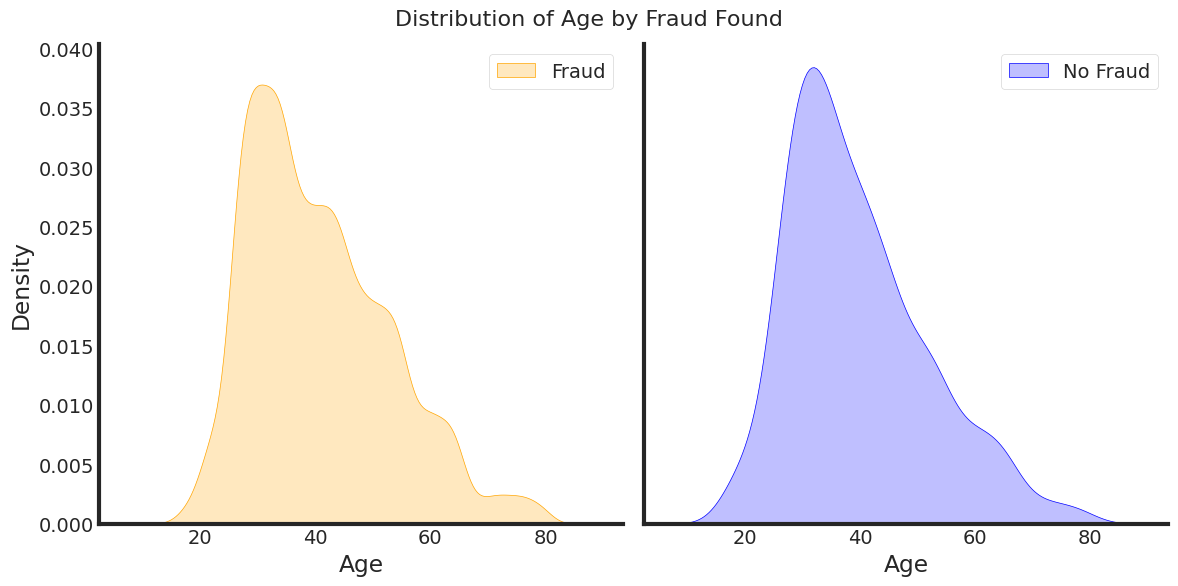

In [ ]:
grid = sns.FacetGrid(df, col='FraudFound_P', height=6, hue_kws={'color': ['orange', 'blue']}, hue="FraudFound_P")

grid.map(sns.kdeplot, 'Age', shade=True)

grid.set_titles("")
grid.fig.suptitle("Distribution of Age by Fraud Found", fontsize=16)

grid.axes[0, 0].legend(['Fraud'])
grid.axes[0, 1].legend(['No Fraud'])

plt.show()

In [ ]:
df_fraud = df[df['FraudFound_P'] == 1]['Sex'].value_counts()
df_no_fraud = df[df['FraudFound_P'] == 0]['Sex'].value_counts()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Fraud', 'No Fraud'])
fig.add_trace(go.Pie(labels=df_fraud.index, values=df_fraud.values, name='Fraud'), 1, 1)
fig.add_trace(go.Pie(labels=df_no_fraud.index, values=df_no_fraud.values, name='No Fraud'), 1, 2)

fig.update_layout(title_text='Breakdown of Gender by Fraud Type')
fig.show()

Overall, the age distributions for both fraudulent and non-fraudulent claims show similar patterns, with peaks around the mid-30s. Moreover, the gender proportions between the two groups are also highly comparable. These findings suggest that the age and gender of the claimant may not serve as strong indicators for determining the fraudulent nature of a claim.

## Vehicle Analysis

### Vehicle Price & Category

In [ ]:
order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

df_fraud = df[df['FraudFound_P'] == 1]['VehiclePrice'].value_counts().reindex(order)
df_no_fraud = df[df['FraudFound_P'] == 0]['VehiclePrice'].value_counts().reindex(order)

fig = make_subplots(rows=1, cols=2, subplot_titles=['Fraud', 'No Fraud'])

fig.add_trace(go.Bar(x=df_fraud.index, y=df_fraud.values, name='Fraud', marker_color='rgba(255, 128, 14, 0.6)'), 1, 1)
fig.add_trace(go.Bar(x=df_no_fraud.index, y=df_no_fraud.values, name='No Fraud', marker_color='rgba(0, 107, 164, 0.6)'), 1, 2)

fig.update_layout(title_text='Distribution of Vehicle Price')
fig.show()

In [ ]:
order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

fig = px.histogram(df, x='VehiclePrice', color='FraudFound_P', facet_col='FraudFound_P', facet_row='VehicleCategory', nbins=50, histnorm='percent', barmode='group', category_orders={'VehiclePrice': order})
fig.update_layout(title_text='Distribution of Vehicle Price by Vehicle Category and Fraud Found', bargap=0.1)
fig.update_yaxes(title_text='')
fig.update_xaxes(title_text='')
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.show()

Fraudulent cases exhibit a substantial proportion of claims made for vehicles priced over $69,000, accounting for 158 claims (18% of total claims), whereas non-fraudulent claims account for 1,688 claims (12% of total claims). 

Further analysis of the vehicle categories reveals that the majority of high-cost fraudulent claims involve Sport and Utility vehicles. This indicates a higher incidence of fraudulent claims for luxury vehicles, specifically in the Sport and Utility categories, particularly at the higher price ranges.

### Age of Vehicle

In [ ]:
order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']

df_fraud = df[df['FraudFound_P'] == 1]['AgeOfVehicle'].value_counts().reindex(order)
df_no_fraud = df[df['FraudFound_P'] == 0]['AgeOfVehicle'].value_counts().reindex(order)

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Fraud', 'No Fraud'])
fig.add_trace(go.Pie(labels=df_fraud.index, values=df_fraud.values, name='Fraud'), 1, 1)
fig.add_trace(go.Pie(labels=df_no_fraud.index, values=df_no_fraud.values, name='No Fraud'), 1, 2)

fig.update_layout(title_text='Breakdown of Gender by Fraud Type')
fig.show()

The visualization indicates that older vehicles (6 years and older) are commonly associated with both fraudulent and non-fraudulent claims, with a higher prevalence in the latter. Newer vehicles (5 years or less) are less common in both types of cases, but particularly less likely to be linked to fraudulent claims.

### Make of Vehicle

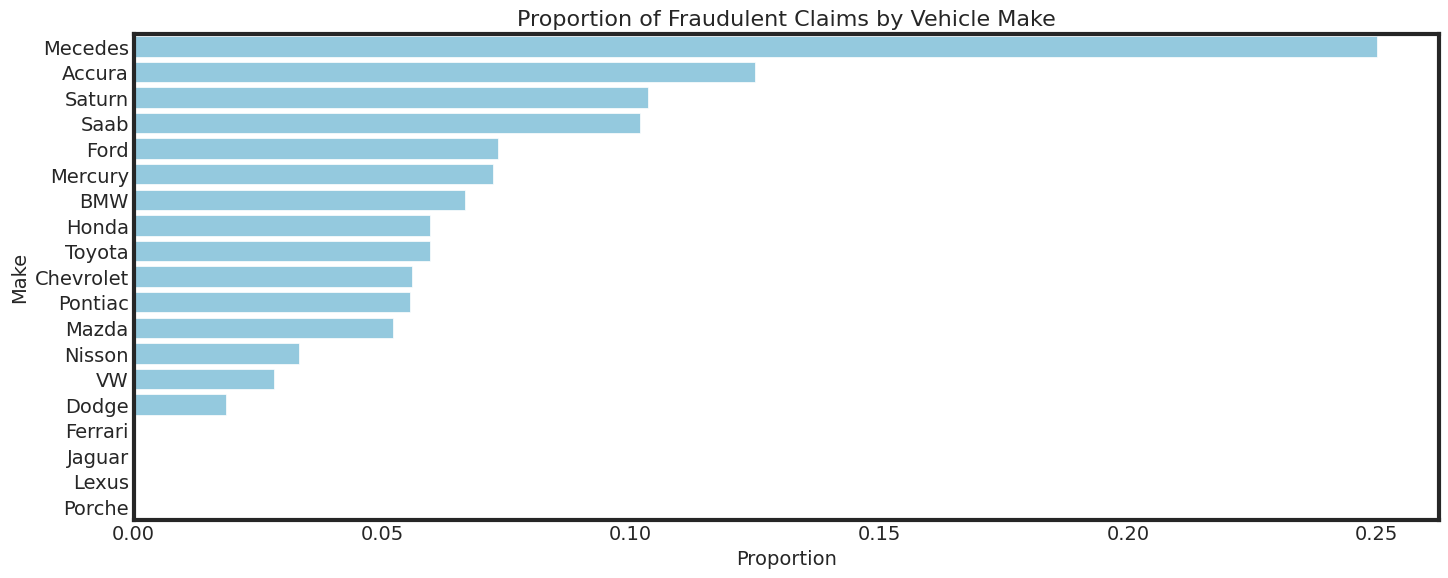

In [ ]:
df_fraud = df[df['FraudFound_P'] == 1]['Make'].value_counts()
df_no_fraud = df[df['FraudFound_P'] == 0]['Make'].value_counts()

df_total = df['Make'].value_counts()
df_fraud_prop = df_fraud / df_total
df_fraud_prop_sorted = df_fraud_prop.sort_values(ascending=False)

sns.barplot(x=df_fraud_prop_sorted.values, y=df_fraud_prop_sorted.index, color='skyblue')
plt.title('Proportion of Fraudulent Claims by Vehicle Make', fontsize=16)
plt.xlabel('Proportion', fontsize=14)
plt.ylabel('Make', fontsize=14)
plt.show()

The 'Mercedes' make has the highest proportion of fraudulent claims at 25%, followed by 'Accura' at 12.5% and 'Saturn' at approximately 10.3%. 'Saab' and 'Ford' also have relatively high proportions of fraudulent claims at around 10.2% and 7.3% respectively.

On the other hand, luxury makes like 'Ferrari', 'Jaguar', 'Lexus', and 'Porche' have no fraudulent claims, as indicated by the NaN values.

## Claims Investigation

### Accident Area

In [ ]:
df_fraud_year = df[df['FraudFound_P'] == 1].groupby(['Accident_Year','AccidentArea'])['FraudFound_P'].count()
df_total_year = df.groupby(['Accident_Year','AccidentArea'])['FraudFound_P'].count()

df_fraud_per_1000_year = (df_fraud_year / df_total_year) * 1000
df_fraud_per_1000_year = df_fraud_per_1000_year.reset_index()
df_fraud_per_1000_year['Accident_Year'] = df_fraud_per_1000_year['Accident_Year'].astype(str)

fig = px.bar(df_fraud_per_1000_year, x='Accident_Year', y='FraudFound_P', color='AccidentArea', title='Number of Fraudulent Claims per 1000 Claims by Accident Area', barmode='group')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Fraudulent Claims per 1000 Claims')
fig.show()


From 2019 to 2020, there were notably more fraudulent claims per 1000 claims in rural areas compared to urban areas. Specifically, in 2019, rural areas had a fraud rate of 113.6, more than double the urban rate of 57.63. Similarly, in 2020, the rural rate was 80.92, considerably higher than the urban rate of 56.32. However, in 2021, this trend reversed, with urban areas showing a higher fraud rate of 53.72 compared to the rural rate of 44.78. This suggests that over these years, there has been a shift in the prevalence of fraud from predominantly rural areas to a nearly even distribution between rural and urban areas.

### Claim Fault

In [ ]:
df_fraud_year = df[df['FraudFound_P'] == 1].groupby(['Accident_Year','Fault'])['FraudFound_P'].count()
df_total_year = df.groupby(['Accident_Year','Fault'])['FraudFound_P'].count()

df_fraud_per_1000_year = (df_fraud_year / df_total_year) * 1000
df_fraud_per_1000_year = df_fraud_per_1000_year.reset_index()
df_fraud_per_1000_year['Accident_Year'] = df_fraud_per_1000_year['Accident_Year'].astype(str)

fig = px.bar(df_fraud_per_1000_year, x='Accident_Year', y='FraudFound_P', color='Fault', title='Number of Fraudulent Claims per 1000 Claims by Fault Type', barmode='group')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Fraudulent Claims per 1000 Claims')
fig.show()


In all three years, the fraudulent claims were considerably higher when the policyholder was at fault compared to when a third party was at fault. Specifically, in 2019, there were 82.88 fraudulent cases per 1,000 claims when the policyholder was at fault compared to 10.58 when a third party was at fault. In 2020, the numbers were 77.80 and 9.21 respectively, and in 2021, they were 71.11 and 6.19. These findings suggest that fraudulent claims are significantly more common when the policyholder is at fault.

### Police Report Filed & Witness Present

In [ ]:
df_fraud_year = df[df['FraudFound_P'] == 1].groupby(['Accident_Year','PoliceReportFiled'])['FraudFound_P'].count()
df_total_year = df.groupby(['Accident_Year','PoliceReportFiled'])['FraudFound_P'].count()

df_fraud_per_1000_year = (df_fraud_year / df_total_year) * 1000
df_fraud_per_1000_year = df_fraud_per_1000_year.reset_index()
df_fraud_per_1000_year['Accident_Year'] = df_fraud_per_1000_year['Accident_Year'].astype(str)
df_fraud_per_1000_year['PoliceReportFiled'] = df_fraud_per_1000_year['PoliceReportFiled'].astype(str)

fig = px.bar(df_fraud_per_1000_year, x='Accident_Year', y='FraudFound_P', color='PoliceReportFiled', title='Number of Fraudulent Claims per 1000 Claims by Police Report Filed', barmode='group')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Fraudulent Claims per 1000 Claims')
fig.show()


In 2019, the rate of fraudulent claims was higher when no police report was filed (64.47) compared to when one was filed (21.58). In contrast, in 2020, the rate of fraudulent claims was almost the same regardless of a police report being filed or not, with 58.84 and 58.44 claims respectively. However, in 2021, similar to 2019, the rate of fraudulent claims was higher when no police report was filed (53.77) as compared to when one was filed (23.81). These findings suggest that the filing of a police report might play a role in decreasing fraudulent claims.

In [ ]:
df_fraud_year = df[df['FraudFound_P'] == 1].groupby(['Accident_Year','WitnessPresent'])['FraudFound_P'].count()
df_total_year = df.groupby(['Accident_Year','WitnessPresent'])['FraudFound_P'].count()

df_fraud_per_1000_year = (df_fraud_year / df_total_year) * 1000
df_fraud_per_1000_year = df_fraud_per_1000_year.reset_index()
df_fraud_per_1000_year['Accident_Year'] = df_fraud_per_1000_year['Accident_Year'].astype(str)
df_fraud_per_1000_year['WitnessPresent'] = df_fraud_per_1000_year['WitnessPresent'].astype(str)

fig = px.bar(df_fraud_per_1000_year, x='Accident_Year', y='FraudFound_P', color='WitnessPresent', title='Number of Fraudulent Claims per 1000 Claims by Witness Present', barmode='group')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Fraudulent Claims per 1000 Claims')
fig.show()

In 2019, there was a higher detection of fraudulent claims when a witness was present at 76.92 per 1000 claims as compared to scenarios without a witness at 63.38 per 1000 claims. However, no fraud was detected in 2020 and 2021 when a witness was present, according to the provided data. Without the presence of a witness, fraudulent claims decreased slightly from 59.22 per 1000 claims in 2020 to 52.99 per 1000 claims in 2021. These findings suggest that the presence of a witness could possibly deter the occurrence of fraudulent claims or improve the efficacy of fraud detection procedures.

### Claim Lag Analysis

Claim lag in the vehicle insurance industry is particularly relevant when considering fraudulent claims. A prolonged claim lag can provide an opportunity for individuals to manipulate or fabricate details of an incident to support a fraudulent claim. The longer the delay between the event and the claim initiation, the higher the potential for fraud, as evidence may be more challenging to collect, witnesses may become less reliable, or the scene of the incident could be altered.

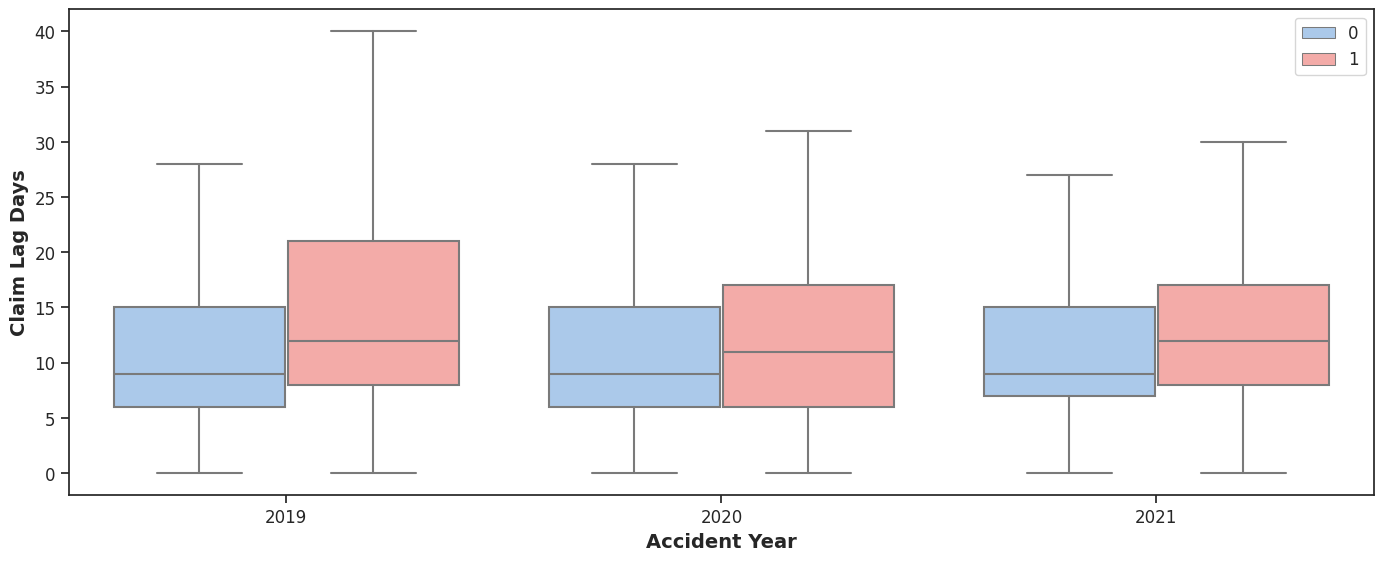

In [ ]:
sns.set_theme(style="ticks", palette="pastel")

ax = sns.boxplot(x="Accident_Year", y="Claim_Lag_Days",
                 hue="FraudFound_P", palette=["b", "r"],
                 data=df, showfliers=False)

font = {'family': 'sans-serif', 'size': 12}
plt.rc('font', **font)

ax.set_xlabel("Accident Year", fontdict={'size': 14, 'weight': 'bold'})
ax.set_ylabel("Claim Lag Days", fontdict={'size': 14, 'weight': 'bold'})

ax.legend(fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()



In [ ]:
df.groupby(['FraudFound_P', 'Accident_Year'])['Claim_Lag_Days'].describe()

count       mean        std  min  25%   50%  \
FraudFound_P Accident_Year                                                 
0            2019           5607.0  14.745140  23.785088  0.0  6.0   9.0   
             2020           4800.0  15.507917  26.019811  0.0  6.0   9.0   
             2021           3801.0  15.049198  25.424894  0.0  7.0   9.0   
1            2019            380.0  20.765789  31.692626  0.0  8.0  12.0   
             2020            300.0  15.660000  19.902380  0.0  6.0  11.0   
             2021            212.0  17.283019  18.522820  0.0  8.0  12.0   

                             75%    max  
FraudFound_P Accident_Year               
0            2019           15.0  361.0  
             2020           15.0  359.0  
             2021           15.0  349.0  
1            2019           21.0  264.0  
             2020           17.0  204.0  
             2021           17.0  113.0

The visualisations above summarises the claim lag results in the vehicle claims data for fraudulent and non-fraudulent claims from 2019 to 2021. The analysis reveals that non-fraudulent claims had an average claim lag of approximately 14-15 days, with a range from 0 to 361 days. In contrast, fraudulent claims had slightly longer average claim lag periods of around 17-21 days, with a range from 0 to 264 days.

In [ ]:
#Perform t-test to test the hypothesis that the average 'Claim_Lag_Days' for fraud cases is larger than for no fraud cases. 
from scipy.stats import ttest_ind

fraud_cases = df[df['FraudFound_P'] == 1]['Claim_Lag_Days']
no_fraud_cases = df[df['FraudFound_P'] == 0]['Claim_Lag_Days']

t_stat, p_value = ttest_ind(fraud_cases, no_fraud_cases, alternative='greater')
t_stat, p_value

(3.6313485513445576, 0.0001414385972391804)

A t-test was conducted to examine whether the average claim lag differs between fraud and non-fraud cases. The test yielded a test statistic (t_stat) of 3.01, with a corresponding p-value of 0.0014.

Given that the p-value is below the significance level of 0.05, we have sufficient evidence to reject the null hypothesis, which assumes that the average claim lag is the same for both fraud and non-fraud cases. Consequently, we can conclude that the average claim lag for fraud cases is significantly greater than that of non-fraud cases at a 5% significance level.

# Data Preprocessing for Fraud Detection Models

In [ ]:
# Set up Libraries
import sklearn
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import plot_roc_curve
from collections import Counter

In [ ]:
drop_columns =['ClaimID', 'CustomerID', 'PolicyNumber', 'VehicleID', 'Accident_Date',
       'Claim_Date','Age_Bin','Accident_Year', 'Accident_DayOfWeek',
       'Claim_Year', 'Claim_DayOfWeek','Accident_Month_Year']
       
cleaned_df = df.drop(drop_columns, axis=1)  
cleaned_df.head(5)

,AccidentArea,Fault,RepNumber,AgentType,Days_Policy_Accident,Days_Policy_Claim,PoliceReportFiled,WitnessPresent,FraudFound_P,Sex,...,AddressChange_Claim,NumberOfCars,VehicleCategory,BasePolicyType,Make,VehiclePrice,AgeOfVehicle,Accident_Month,Claim_Month,Claim_Lag_Days
0,Urban,Policy Holder,12,External,more than 30,more than 30,0,0,0,Female,...,1 year,3 to 4,Sport,Liability,Honda,more than 69000,3 years,Dec,Jan,6
1,Urban,Policy Holder,15,External,more than 30,more than 30,1,0,0,Male,...,no change,1 vehicle,Sport,Collision,Honda,more than 69000,6 years,Jan,Jan,12
2,Urban,Policy Holder,7,External,more than 30,more than 30,0,0,0,Male,...,no change,1 vehicle,Sport,Collision,Honda,more than 69000,7 years,Oct,Nov,20
3,Rural,Third Party,4,External,more than 30,more than 30,1,0,0,Male,...,no change,1 vehicle,Sedan,Liability,Toyota,20000 to 29000,more than 7,Jun,Jul,27
4,Urban,Third Party,3,External,more than 30,more than 30,0,0,0,Female,...,no change,1 vehicle,Sport,Collision,Honda,more than 69000,5 years,Jan,Feb,22


In [ ]:
print(cleaned_df.columns)

Index(['AccidentArea', 'Fault', 'RepNumber', 'AgentType',
       'Days_Policy_Accident', 'Days_Policy_Claim', 'PoliceReportFiled',
       'WitnessPresent', 'FraudFound_P', 'Sex', 'MaritalStatus', 'Age',
       'DriverRating', 'Deductible', 'PastNumberOfClaims',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'VehicleCategory', 'BasePolicyType', 'Make', 'VehiclePrice',
       'AgeOfVehicle', 'Accident_Month', 'Claim_Month', 'Claim_Lag_Days'],
      dtype='object')


## Encoding Categorical Features

In [ ]:
# Encode Non-Ordinal Features
binary_columns = ['AccidentArea', 'Fault','Sex','MaritalStatus',
        'VehicleCategory', 'BasePolicyType', 'Make','AgentType']

encoder = LabelEncoder()

for column in binary_columns:
    cleaned_df[column] = encoder.fit_transform(cleaned_df[column])

In [ ]:
# Encode Ordinal Features
ord_columns = ['Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
               'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
               'VehiclePrice', 'AgeOfVehicle','Accident_Month', 'Claim_Month']

ord_mapping = [
    {'Days_Policy_Accident': {'none': 0, '1 to 7': 1, '8 to 15': 8, '15 to 30': 15, 'more than 30': 31}},
    {'Days_Policy_Claim': {'more than 30': 31, '15 to 30': 15, '8 to 15': 8, 'none': 0}},
    {'PastNumberOfClaims': {'none': 0, '1': 1, '2 to 4': 2, 'more than 4': 5}},
    {'NumberOfSuppliments': {'none': 0, '1 to 2': 1, '3 to 5': 3, 'more than 5': 6}},
    {'AddressChange_Claim': {'1 year': 1, 'no change': 0, '4 to 8 years': 6, '2 to 3 years': 2, 'under 6 months': 0.5}},
    {'NumberOfCars': {'3 to 4': 3, '1 vehicle': 1, '2 vehicles': 2, '5 to 8': 5, 'more than 8': 9}},
    {'VehiclePrice': {'more than 69000':69001,'20000 to 29000':24500,'30000 to 39000':34500,'less than 20000':19999,
                                     '40000 to 59000':49500,'60000 to 69000':64500}},
    {'AgeOfVehicle': {'3 years': 3, '6 years': 6, '7 years': 7, 'more than 7': 8, '5 years': 5, 'new': 0,
                                         '4 years': 4, '2 years': 2}},
    {'Accident_Month':{'Dec':12, 'Jan':1, 'Oct':10, 'Jun':6, 'Feb':2, 'Apr':4, 'Mar':3, 'Aug':8, 'Jul':7, 'May':5, 'Sep':9, 'Nov':11}},
    {'Claim_Month':{'Dec':12, 'Jan':1, 'Oct':10, 'Jun':6, 'Feb':2, 'Apr':4, 'Mar':3, 'Aug':8, 'Jul':7, 'May':5, 'Sep':9, 'Nov':11}}
]

for i in range(len(ord_mapping)):
    cleaned_df.replace(ord_mapping[i], inplace=True)

In [ ]:
#Transform VehiclePrice column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cleaned_df['VehiclePrice'] = scaler.fit_transform(cleaned_df[['VehiclePrice']])

In [ ]:
# Confirm features have been encoded
cleaned_df.dtypes

AccidentArea              int64
Fault                     int64
RepNumber                 int64
AgentType                 int64
Days_Policy_Accident      int64
Days_Policy_Claim         int64
PoliceReportFiled         int64
WitnessPresent            int64
FraudFound_P              int64
Sex                       int64
MaritalStatus             int64
Age                       int64
DriverRating              int64
Deductible                int64
PastNumberOfClaims        int64
NumberOfSuppliments       int64
AddressChange_Claim     float64
NumberOfCars              int64
VehicleCategory           int64
BasePolicyType            int64
Make                      int64
VehiclePrice            float64
AgeOfVehicle              int64
Accident_Month            int64
Claim_Month               int64
Claim_Lag_Days            int64
dtype: object

# Detecting Fraudulent Claims with ML

In the beginning of the EDA, we saw that the original data frame was heavily imbalanced. Creating a sub-sample is crucial when dealing with imbalanced datasets, such as our 'FraudFound_P' dataset for the following reasons:

1. Avoid Overfitting: In our original dataset, most of the insurance claims were not fraudulent. If we use this imbalanced dataset, our classification model will be biased towards predicting that most transactions are not fraudulent. This is a problem because we want our model to accurately identify when a fraudulent transaction occurs.

2. Correct Correlations: Our dataset contains many features that may influence whether a transaction is fraudulent or not. However, if our dataset is imbalanced, we might not get a true understanding of these relationships. By balancing our dataset, we can better understand how each feature correlates with our target variable (fraudulent or not).

## Undersampling the Target Feature

In the next phase of this project, we will apply the NearMiss undersampling method to tackle the class imbalance in our dataset. NearMiss, an intelligent undersampling technique, reduces instances of the majority class based on their distances to minority class instances. This method particularly focuses on the instances that are hard-to-classify, aiming to create a more definitive boundary between the classes and potentially improving model performance.

After employing NearMiss to our training set, we will utilize the resampled dataset to train several classifier models. Their performance will be evaluated using the F1-score, a harmonized measure of precision and recall that offers a balanced perspective, especially when dealing with class imbalances. This strategic approach allows our models to learn more effectively from the minority class, enhancing overall accuracy.

![Logo](/work/uwf3vkip.png)

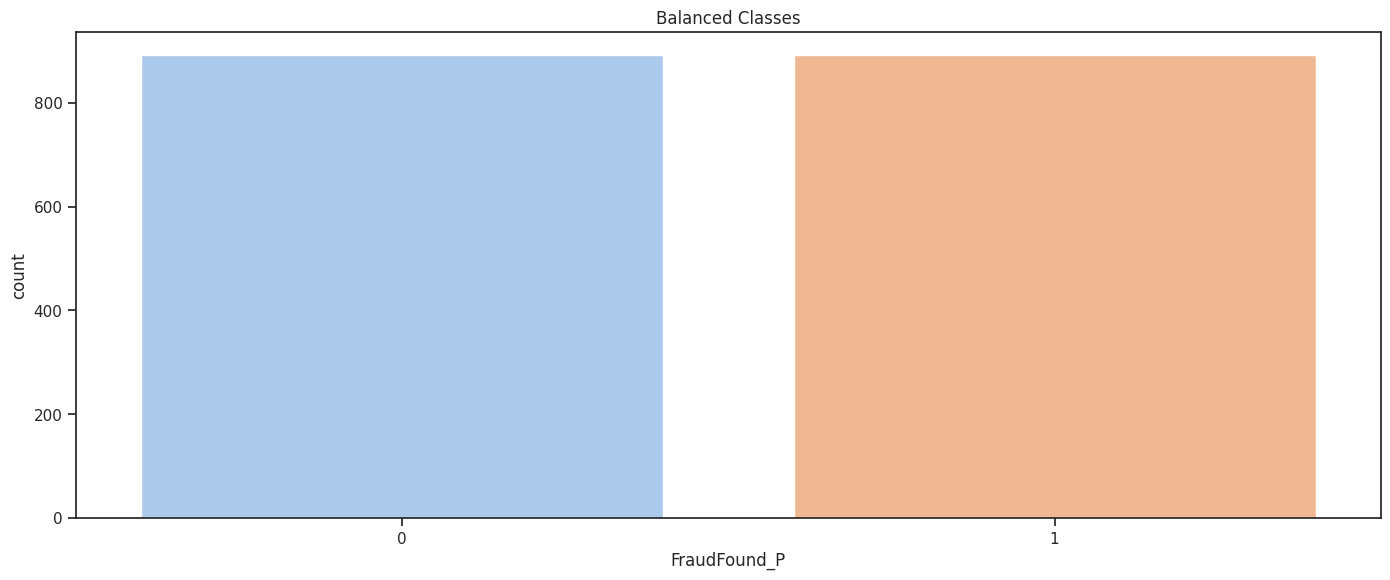

In [ ]:
# Shuffle the Dataset.
shuffled_df = cleaned_df.sample(frac=1,random_state=seed)

# amount of fraud claims 892 rows.
fraud_df = shuffled_df.loc[shuffled_df['FraudFound_P'] == 1]

#Randomly select 892 non-fraud observations.
non_fraud_df = shuffled_df.loc[shuffled_df['FraudFound_P'] == 0].sample(n=892,random_state=seed)
normalized_df = pd.concat([fraud_df, non_fraud_df])

sns.countplot(data=normalized_df, x='FraudFound_P')
plt.title('Balanced Classes')
plt.show()

In [ ]:
#Shuffle the normalized dataset before splitting
model_df = normalized_df.sample(frac=1, random_state=seed)
model_df.head(5)

,AccidentArea,Fault,RepNumber,AgentType,Days_Policy_Accident,Days_Policy_Claim,PoliceReportFiled,WitnessPresent,FraudFound_P,Sex,...,AddressChange_Claim,NumberOfCars,VehicleCategory,BasePolicyType,Make,VehiclePrice,AgeOfVehicle,Accident_Month,Claim_Month,Claim_Lag_Days
13931,1,1,5,0,31,31,1,0,0,1,...,0.0,1,1,1,9,2.409450,7,8,8,19
10092,1,0,7,0,31,31,0,0,0,0,...,0.0,1,0,2,13,-0.564480,7,12,12,10
2190,1,0,2,0,31,31,0,0,1,1,...,0.0,1,0,0,5,-0.865274,8,3,4,18
13849,1,0,7,0,31,31,0,0,0,1,...,0.0,1,0,1,9,-0.564480,8,1,1,8
6128,1,0,12,0,31,31,1,0,1,1,...,0.0,1,0,1,9,-0.564480,5,9,9,2


In [ ]:
# Split the data into features and target
X = model_df.drop('FraudFound_P', axis=1)
y = model_df['FraudFound_P']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

## Correlation Matrices

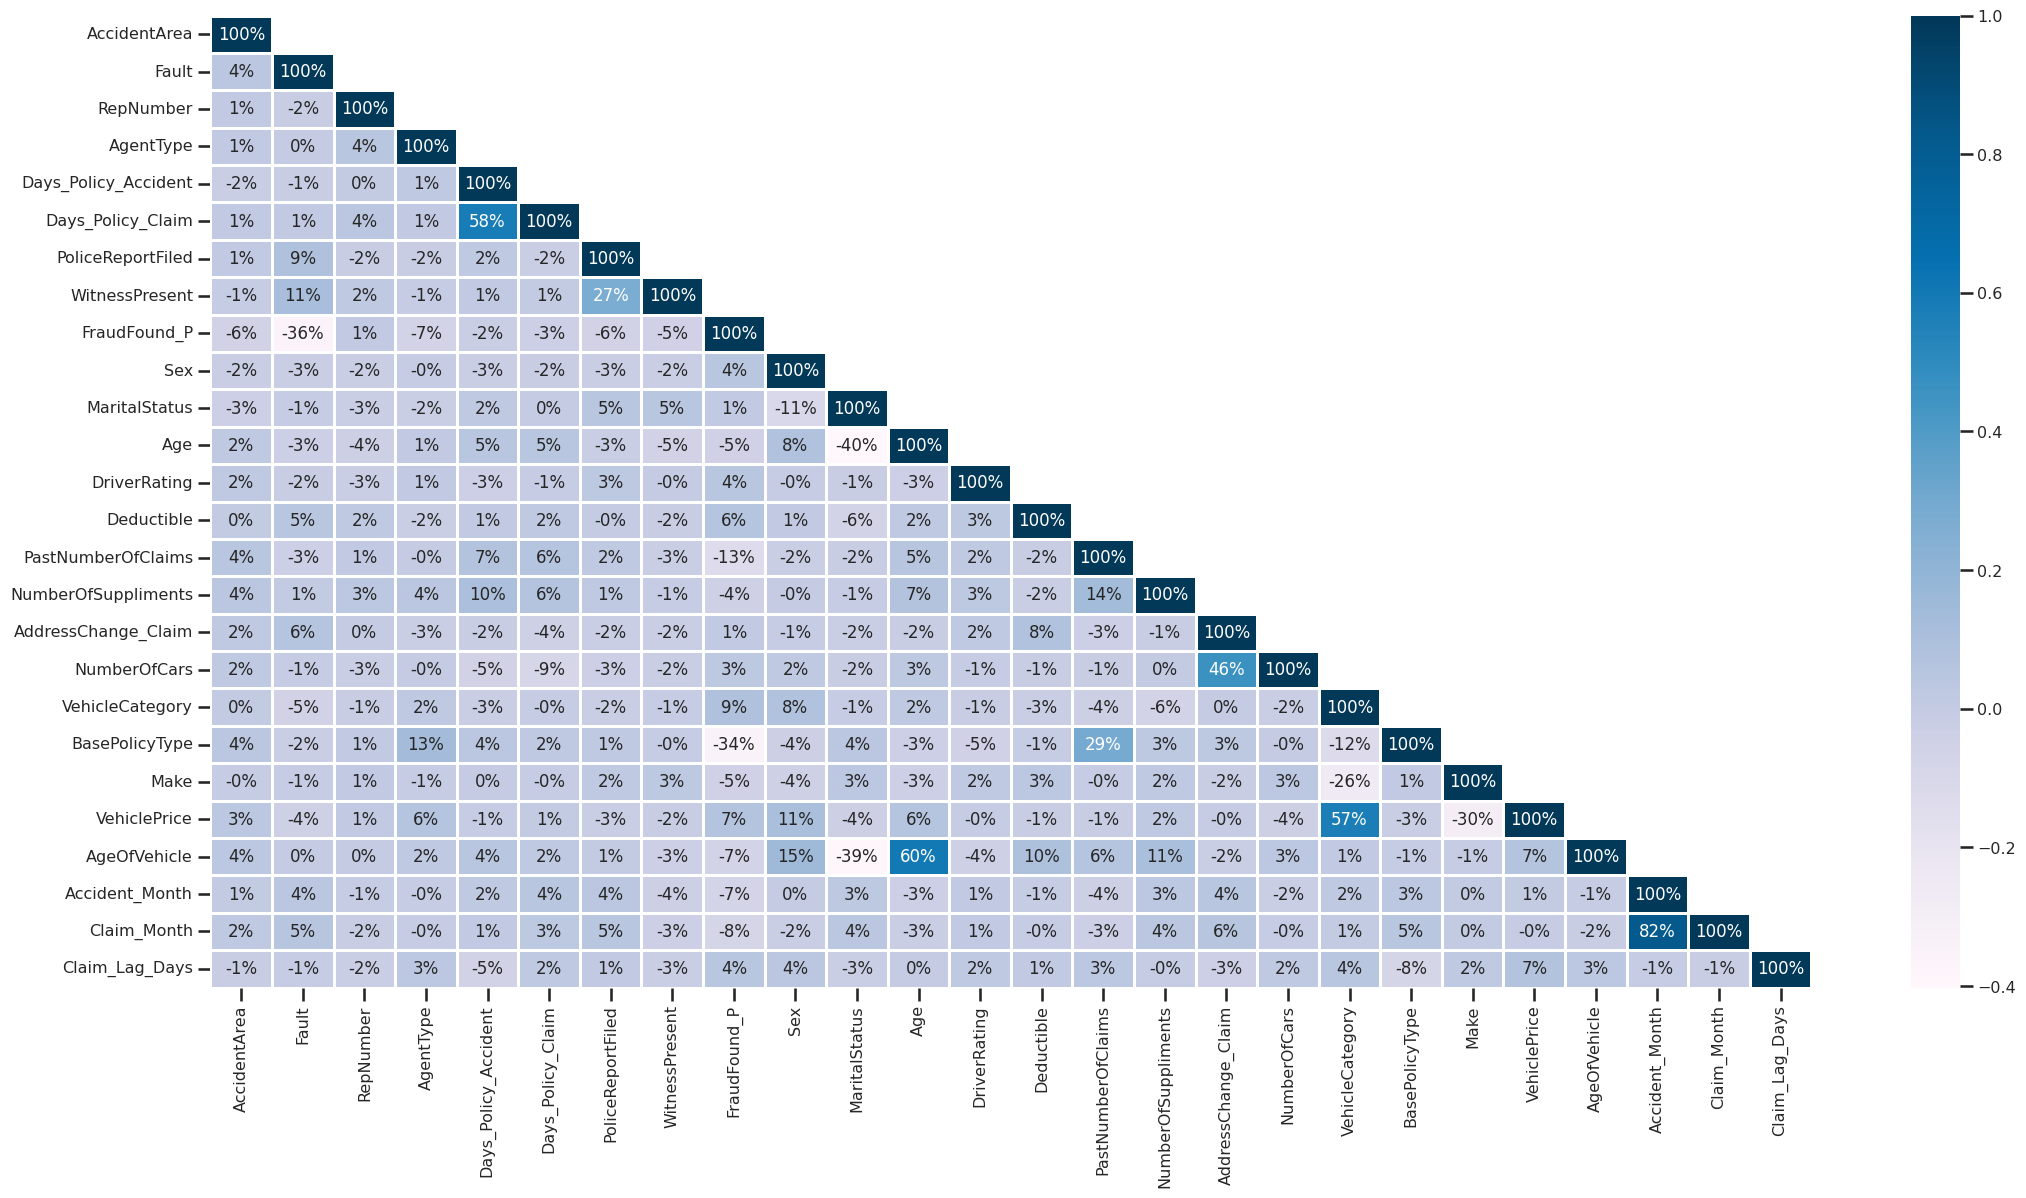

In [ ]:
mpl.rcParams['figure.figsize'] = (23, 12)
sns.set_context('talk', font_scale=0.7)

sns.heatmap(model_df.corr(method='pearson').where(
    np.tril(np.ones(model_df.corr(method='pearson').shape)).astype(np.bool)),
            cmap='PuBu',
            linewidths=1,
            annot=True,
            annot_kws={"size": 12},
            fmt=".0%")
plt.show()

## Classifiers

### Build Models

In [ ]:
# Initialize classifier models
classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=seed),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=seed),
    "RandomForestClassifier": RandomForestClassifier(random_state=seed),
    "XGBClassifier": XGBClassifier(random_state=seed)
}

In [ ]:
from sklearn.model_selection import cross_val_score

# Fit classifiers and apply cross validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
    print("Classifiers: ", classifier.__class__.__name__, "has a Training F1-score of", 
            round(training_score.mean() * 100,1), "%")


Classifiers:  LogisticRegression has a Training F1-score of 68.0 %
Classifiers:  DecisionTreeClassifier has a Training F1-score of 71.1 %
Classifiers:  RandomForestClassifier has a Training F1-score of 78.4 %
Classifiers:  XGBClassifier has a Training F1-score of 72.9 %


The performance evaluation of our classification models, based on the F1-score, yielded the following outcomes. The RandomForestClassifier performed the best, achieving an F1-score of 78.4%. This signifies a strong combination of precision and recall, resulting in high accuracy in identifying both fraudulent and non-fraudulent claims.

The XGBClassifier and DecisionTreeClassifier demonstrated similar performances with F1-scores of 72.9% and 71.1% respectively. These scores indicate a good balance between precision and recall in identifying fraudulent claims. However, the LogisticRegression model had the lowest F1-score of 67.7%, suggesting it may not perform as effectively in distinguishing between the classes compared to the other models.

These results serve as a reliable benchmark for further tuning and comparison of the models as we progress in our analysis

### Hyperparameters Tuning

In [ ]:
# Use GridSearchCV to find the best parameters
from sklearn.model_selection import RandomizedSearchCV

# Logistic Regression 
log_reg_params = {
    "penalty": ['l1', 'l2'], 
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "max_iter": [50, 100, 200]
}
grid_log_reg = RandomizedSearchCV(LogisticRegression(random_state=seed), log_reg_params,n_iter=100, cv=5, random_state=seed)
grid_log_reg.fit(X_train, y_train)
# Get the logistic regression with the best parameters
log_reg = grid_log_reg.best_estimator_

# DecisionTree Classifier
tree_params = {
    "criterion": ["gini", "entropy"], 
    "max_depth": list(range(2, 10, 2)), 
    "min_samples_leaf": list(range(1, 5, 1)),  
    "min_samples_split": list(range(2, 10, 2)),
    "splitter": ['best', 'random'],
    "max_features": ['auto', 'sqrt', 'log2', None]
}
grid_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=seed), tree_params,n_iter=100, cv=5,random_state=seed)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

# RandomForest Classifier
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion':['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}
grid_rf = RandomizedSearchCV(RandomForestClassifier(random_state=seed), rf_params,n_iter=100, cv=5, random_state=seed)
grid_rf.fit(X_train, y_train)
randomforest = grid_rf.best_estimator_

XGB Classifier Hyperparameters

In [ ]:
# import packages for XGB hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from timeit import default_timer as timer

space = {
    'learning_rate' :hp.uniform('learning_rate', 0.01,0.3),
    'n_estimators': hp.choice('n_estimators', range(10, 100)),
    'max_depth': hp.choice('max_depth', range(1, 50)),
    'gamma': hp.uniform('gamma', 1, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'random_state': seed
}

In [ ]:
def objective(space):
    clf=XGBClassifier(
    learning_rate=space['learning_rate'],
    n_estimators =space['n_estimators'],
    max_depth = space['max_depth'],
    gamma = space['gamma'],
    reg_alpha = space['reg_alpha'],
    reg_lambda = space['reg_lambda'],
    min_child_weight=space['min_child_weight'],
    colsample_bytree=space['colsample_bytree'],
    random_state= space['random_state'])
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7843137254901961
SCORE:
0.7899159663865546
SCORE:
0.7871148459383753
SCORE:
0.7759103641456583
SCORE:
0.7815126050420168
SCORE:
0.7899159663865546
SCORE:
0.7815126050420168
SCORE:
0.7787114845938375
SCORE:
0.7759103641456583
SCORE:
0.7815126050420168
SCORE:
0.7787114845938375
SCORE:
0.7759103641456583
SCORE:
0.7787114845938375
SCORE:
0.7815126050420168
SCORE:
0.7899159663865546
SCORE:
0.7815126050420168
SCORE:
0.7843137254901961
SCORE:
0.7787114845938375
SCORE:
0.7787114845938375
SCORE:
0.7871148459383753
SCORE:
0.7843137254901961
SCORE:
0.7703081232492998
SCORE:
0.7591036414565826
SCORE:
0.7899159663865546
SCORE:
0.7871148459383753
SCORE:
0.7787114845938375
SCORE:
0.7843137254901961
SCORE:
0.7787114845938375
SCORE:
0.773109243697479
SCORE:
0.8011204481792717
SCORE:
0.7899159663865546
SCORE:
0.7675070028011205
SCORE:
0.7675070028011205
SCORE:
0.773109243697479
SCORE:
0.7787114845938375
SCORE:
0.773109243697479
SCORE:
0.7675070028011205
SCORE:
0.742296918767507
SCORE:
0.7731092

In [ ]:
print("The best XGB hyperparameters are : ","\n")
print(best_hyperparams)

The best XGB hyperparameters are :  

{'colsample_bytree': 0.9873164744002625, 'gamma': 3.590408844661674, 'learning_rate': 0.26841143048981664, 'max_depth': 37, 'min_child_weight': 2.0, 'n_estimators': 35, 'reg_alpha': 0.7566494764103018, 'reg_lambda': 0.7542557916019684}


In [ ]:
#The best XGB hyperparameters are : {'colsample_bytree': 0.5430303710534126, 'gamma': 1.7847791857293178, 
#'learning_rate': 0.08957712763660754, 'max_depth': 21, 'min_child_weight': 1.0, 'n_estimators': 67, 
#'reg_alpha': 0.7845888994003145, 'reg_lambda': 0.49113994322132365}



xgb_clf = XGBClassifier(
    colsample_bytree=0.5430303710534126, 
    gamma=  1.7847791857293178, 
    learning_rate= 0.08957712763660754,
    max_depth=21,
    min_child_weight=1.0, 
    n_estimators=67, 
    reg_alpha=0.7845888994003145,
    reg_lambda=0.49113994322132365
)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5430303710534126, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.7847791857293178, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08957712763660754, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=21, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=67, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Hyperparameter Optimization Results

In [ ]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
print('Logistic Regression Cross Validation F1-Score: ', round(log_reg_score.mean() * 100, 1).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='f1')
print('DecisionTree Classifier Cross Validation F1-Score', round(tree_score.mean() * 100, 1).astype(str) + '%')

rf_score = cross_val_score(randomforest, X_train, y_train, cv=5, scoring='f1')
print('RandomForest Classifier Cross Validation F1-Score', round(rf_score.mean() * 100, 1).astype(str) + '%')

xgb_score = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1')
print('XGB Classifier Cross Validation F1-Score', round(xgb_score.mean() * 100, 1).astype(str) + '%')

Logistic Regression Cross Validation F1-Score:  74.6%
DecisionTree Classifier Cross Validation F1-Score 79.6%
RandomForest Classifier Cross Validation F1-Score 79.9%
XGB Classifier Cross Validation F1-Score 77.5%


Upon conducting hyperparameter tuning, appreciable enhancements in the performance of the classifiers were observed. The **Logistic Regression** model, which is relatively simple, showed a notable improvement, with its F1-score increasing from 67.7% to **74.6%**.

The **Decision Tree Classifier** experienced the most significant increase in its F1-score, jumping from 71.1% to **79.6%**. This demonstrated that significant gains can be achieved from tuning hyperparameters, even in relatively straightforward models.

Meanwhile, the **RandomForest Classifier**, already a strong performer, displayed a modest performance boost, with its F1-score edging forward from 78.4% to **79.9%**. The **XGB Classifier** also showed a reasonable improvement, increasing its score from 72.9% to **77.5%**. Despite the changes in performance for the other classifiers, the RandomForest Classifier remained the top-performing model in terms of F1-score post-tuning.

These results underline the importance of hyperparameter optimization. However, it is crucial to remember that such tuning might not always lead to improvements for every model, and the extent of enhancement can vary depending on multiple factors like the model's complexity, data characteristics, initial hyperparameters, and the tuning method used. Finally, models should also be assessed for potential overfitting and their performance on unseen data despite any improvements in F1-score.

### Plot ROC Curves

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression
log_reg_train_probs = log_reg.predict(X_train)
log_reg_test_probs = log_reg.predict(X_test)

# Decision Tree Classifier
tree_train_probs = tree_clf.predict(X_train)
tree_test_probs = tree_clf.predict(X_test)

# Random Forest Classifier
rf_train_probs = randomforest.predict(X_train)
rf_test_probs = randomforest.predict(X_test)

# XGBoost Classifier
xgb_train_probs = xgb_clf.predict(X_train)
xgb_test_probs = xgb_clf.predict(X_test)

In [ ]:
# Logistic Regression
log_reg_auc_train = roc_auc_score(y_train, log_reg_train_probs)
log_reg_auc_test = roc_auc_score(y_test, log_reg_test_probs)

# Decision Tree Classifier
tree_auc_train = roc_auc_score(y_train, tree_train_probs)
tree_auc_test = roc_auc_score(y_test, tree_test_probs)

# Random Forest Classifier
rf_auc_train = roc_auc_score(y_train, rf_train_probs)
rf_auc_test = roc_auc_score(y_test, rf_test_probs)

# XGBoost Classifier
xgb_auc_train = roc_auc_score(y_train, xgb_train_probs)
xgb_auc_test = roc_auc_score(y_test, xgb_test_probs)

In [ ]:
# Print ROC scores for training set
print('ROC Scores - Training Set')
print('Logistic Regression: ', round(log_reg_auc_train, 3))
print('Decision Tree Classifier: ', round(tree_auc_train, 3))
print('Random Forest Classifier: ', round(rf_auc_train, 3))
print('XGBoost Classifier: ', round(xgb_auc_train, 3))
print()

# Print ROC scores for test set
print('ROC Scores - Test Set')
print('Logistic Regression: ', round(log_reg_auc_test, 3))
print('Decision Tree Classifier: ', round(tree_auc_test, 3))
print('Random Forest Classifier: ', round(rf_auc_test, 3))
print('XGBoost Classifier: ', round(xgb_auc_test, 3))

ROC Scores - Training Set
Logistic Regression:  0.731
Decision Tree Classifier:  0.777
Random Forest Classifier:  0.834
XGBoost Classifier:  0.906

ROC Scores - Test Set
Logistic Regression:  0.759
Decision Tree Classifier:  0.778
Random Forest Classifier:  0.792
XGBoost Classifier:  0.77


The ROC scores reveal varying performance of the classifiers on the training and test sets. On the training set, the XGBoost Classifier demonstrates superior performance with a ROC score of 0.906, followed by the RandomForest Classifier at 0.834. The Logistic Regression and Decision Tree models show slightly lower performance with scores of 0.731 and 0.777, respectively.

However, the models' performance on the test set indicates the RandomForest Classifier generalizes best on unseen data, achieving a ROC score of 0.792. The Decision Tree Classifier, Logistic Regression, and XGBoost Classifier follow closely, with scores of 0.778, 0.759, and 0.770 respectively. Despite the XGBoost Classifier's leading performance during training, its slight drop in the test score highlights the RandomForest Classifier's better balance between bias and variance, making it the most reliable model for this task. These results underscore the importance of assessing models on both training and test sets to ensure robust performance.

In [ ]:
# Logistic Regression
log_reg_fpr_train, log_reg_tpr_train, _ = roc_curve(y_train, log_reg_train_probs)
log_reg_fpr_test, log_reg_tpr_test, _ = roc_curve(y_test, log_reg_test_probs)

# Decision Tree Classifier
tree_fpr_train, tree_tpr_train, _ = roc_curve(y_train, tree_train_probs)
tree_fpr_test, tree_tpr_test, _ = roc_curve(y_test, tree_test_probs)

# Random Forest Classifier
rf_fpr_train, rf_tpr_train, _ = roc_curve(y_train, rf_train_probs)
rf_fpr_test, rf_tpr_test, _ = roc_curve(y_test, rf_test_probs)

# XGBoost Classifier
xgb_fpr_train, xgb_tpr_train, _ = roc_curve(y_train, xgb_train_probs)
xgb_fpr_test, xgb_tpr_test, _ = roc_curve(y_test, xgb_test_probs)

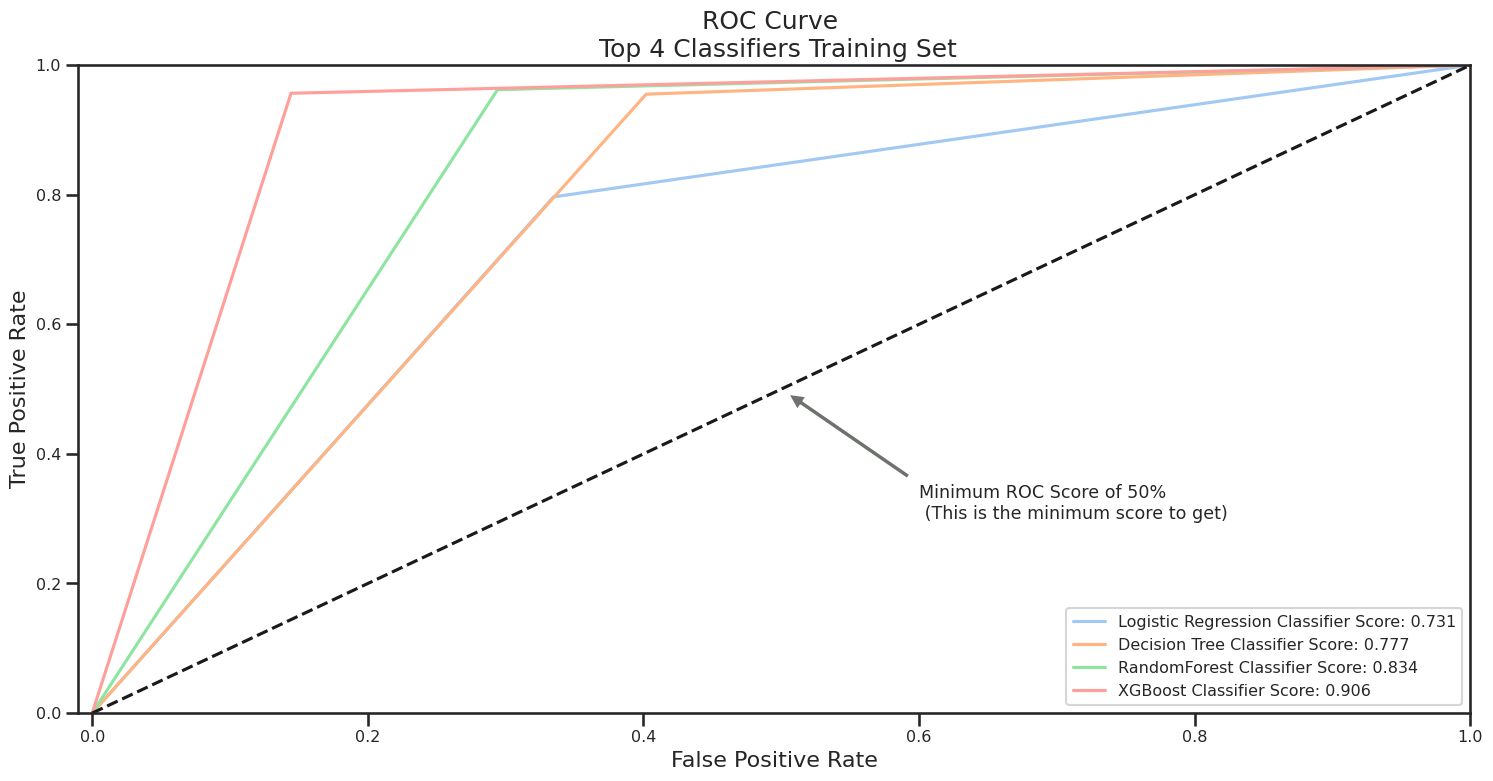

In [ ]:

def graph_roc_curve_multiple(log_reg_fpr_train, log_reg_tpr_train, tree_fpr_train, tree_tpr_train,rf_fpr_train, rf_tpr_train,xgb_fpr_train, xgb_tpr_train):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers Training Set', fontsize=18)
    plt.plot(log_reg_fpr_train, log_reg_tpr_train, label='Logistic Regression Classifier Score: {:.3f}'.format(log_reg_auc_train))
    plt.plot(tree_fpr_train, tree_tpr_train, label='Decision Tree Classifier Score: {:.3f}'.format(tree_auc_train))
    plt.plot(rf_fpr_train, rf_tpr_train, label='RandomForest Classifier Score: {:.3f}'.format(rf_auc_train))
    plt.plot(xgb_fpr_train, xgb_tpr_train, label='XGBoost Classifier Score: {:.3f}'.format(xgb_auc_train))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_reg_fpr_train, log_reg_tpr_train, tree_fpr_train, tree_tpr_train,rf_fpr_train, rf_tpr_train,xgb_fpr_train, xgb_tpr_train)
plt.show()

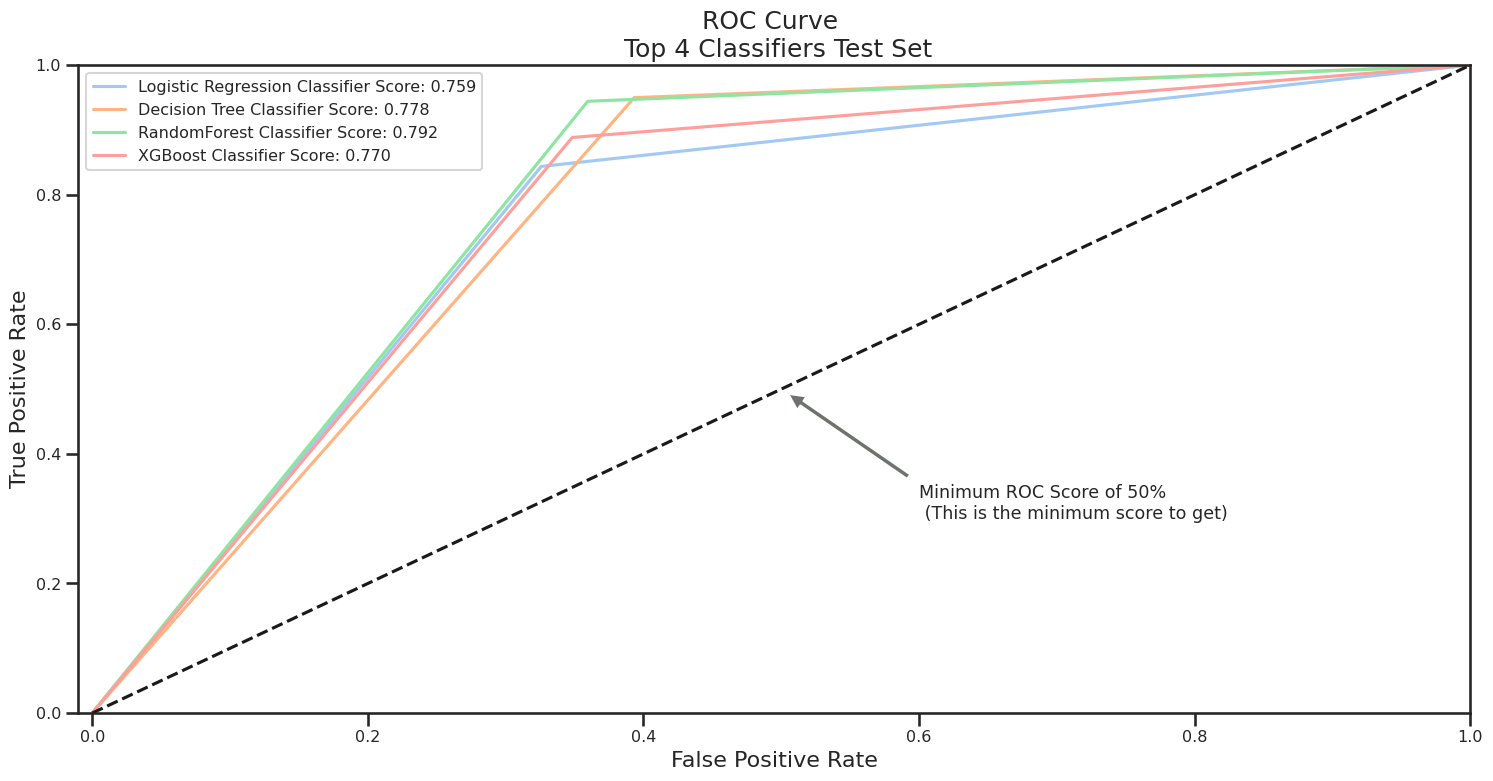

In [ ]:
def graph_roc_curve_multiple(log_reg_fpr_test, log_reg_tpr_test, tree_fpr_test, tree_tpr_test, rf_fpr_test, rf_tpr_test, xgb_fpr_test, xgb_tpr_test):
    plt.figure(figsize=(16, 8))
    plt.title('ROC Curve \n Top 4 Classifiers Test Set', fontsize=18)
    plt.plot(log_reg_fpr_test, log_reg_tpr_test, label='Logistic Regression Classifier Score: {:.3f}'.format(log_reg_auc_test))
    plt.plot(tree_fpr_test, tree_tpr_test, label='Decision Tree Classifier Score: {:.3f}'.format(tree_auc_test))
    plt.plot(rf_fpr_test, rf_tpr_test, label='RandomForest Classifier Score: {:.3f}'.format(rf_auc_test))
    plt.plot(xgb_fpr_test, xgb_tpr_test, label='XGBoost Classifier Score: {:.3f}'.format(xgb_auc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()

graph_roc_curve_multiple(log_reg_fpr_test, log_reg_tpr_test, tree_fpr_test, tree_tpr_test, rf_fpr_test, rf_tpr_test, xgb_fpr_test, xgb_tpr_test)
plt.show()


### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Logistic Regression
log_reg_report = classification_report(y_test, log_reg.predict(X_test))
print("Logistic Regression Classification Report:")
print(log_reg_report)

# Decision Tree Classifier
tree_clf_report = classification_report(y_test, tree_clf.predict(X_test))
print("Decision Tree Classifier Classification Report:")
print(tree_clf_report)

# Random Forest Classifier
rf_report = classification_report(y_test, randomforest.predict(X_test))
print("Random Forest Classifier Classification Report:")
print(rf_report)

# XGBoost Classifier
xgb_report = classification_report(y_test, xgb_clf.predict(X_test))
print("XGBoost Classifier Classification Report:")
print(xgb_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.74       178
           1       0.72      0.84      0.78       179

    accuracy                           0.76       357
   macro avg       0.77      0.76      0.76       357
weighted avg       0.77      0.76      0.76       357

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       178
           1       0.71      0.95      0.81       179

    accuracy                           0.78       357
   macro avg       0.82      0.78      0.77       357
weighted avg       0.82      0.78      0.77       357

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       178
           1       0.73      0.94      0.82       179

    accuracy                           0.79

## Model Summary

This report evaluates four machine learning classifiers - Logistic Regression, Decision Tree Classifier, Random Forest Classifier, and XGBoost Classifier. The focus is on predicting class 1, which represents fraudulent claims. The evaluation of these models was based on their precision, recall, F1-scores for class 1 on unseen test data, training/test ROC scores, and training cross-validation F1-scores.

**Logistic Regression:**

Logistic Regression exhibited a precision of 0.72, recall of 0.84, and an F1-score of 0.78 for class 1. The model yielded an ROC score of 0.731 on the training set and 0.759 on the test set. The cross-validation F1-score stood at 74.6%.

**Decision Tree Classifier:**

The Decision Tree Classifier achieved a precision of 0.71, recall of 0.95, and an F1-score of 0.81 for class 1. It generated ROC scores of 0.777 and 0.778 for the training set and the test set, respectively. The cross-validation F1-score was 79.6%. The model demonstrated a high recall rate, suggesting a strong ability in identifying fraudulent cases, though it may result in more false positives.

**Random Forest Classifier:**

The Random Forest Classifier displayed a precision of 0.73, recall of 0.94, and an F1-score of 0.82 for class 1, showcasing strong performance in predicting fraudulent claims. The model produced ROC scores of 0.834 and 0.792 for the training and test sets, respectively. It yielded a cross-validation F1-score of 79.9%, further attesting to its robust performance across multiple data splits.

**XGBoost Classifier:**

The XGBoost Classifier demonstrated a precision of 0.72, recall of 0.89, and an F1-score of 0.80 for class 1. It registered an ROC score of 0.906 on the training set and 0.77 on the test set. The cross-validation F1-score was 77.5%. While the model performed well in identifying fraudulent cases, it was slightly surpassed by the Random Forest Classifier in terms of F1-score and ROC score.

In conclusion, based on the F1-scores for predicting fraudulent insurance claims, as well as the ROC and cross-validation F1-scores, the **Random Forest Classifier** stands out as the most effective model among the four evaluated classifiers for predicting fraudulent insurance claims.

## Feature Importance

The table and accompanying visualizations below represent the importance of each feature as used by a Random Forest Classifier for its predictions. The "importance" metric signifies the degree of influence each feature holds on the predictive model. The feature labeled "Fault" ranks as the most influential with an importance value of roughly 0.24, indicating its substantial role in the model's predictive decisions. "BasePolicyType" is a close contender, demonstrating a high degree of influence with its importance measured at approximately 0.23.

Most of the remaining features exhibit considerably less importance. For example, the third most influential feature, "Claim_Lag_Days," has an importance value of roughly 0.08. It's important to note that some features, such as "WitnessPresent," "Days_Policy_Claim," and "AgentType," have particularly low importance scores, suggesting their impact on the model's predictions is minimal. Despite varying levels of importance, all features collectively contribute to the model's predictions. However, the importance value provides a measure of each feature's relative impact on the decision-making process of the model.

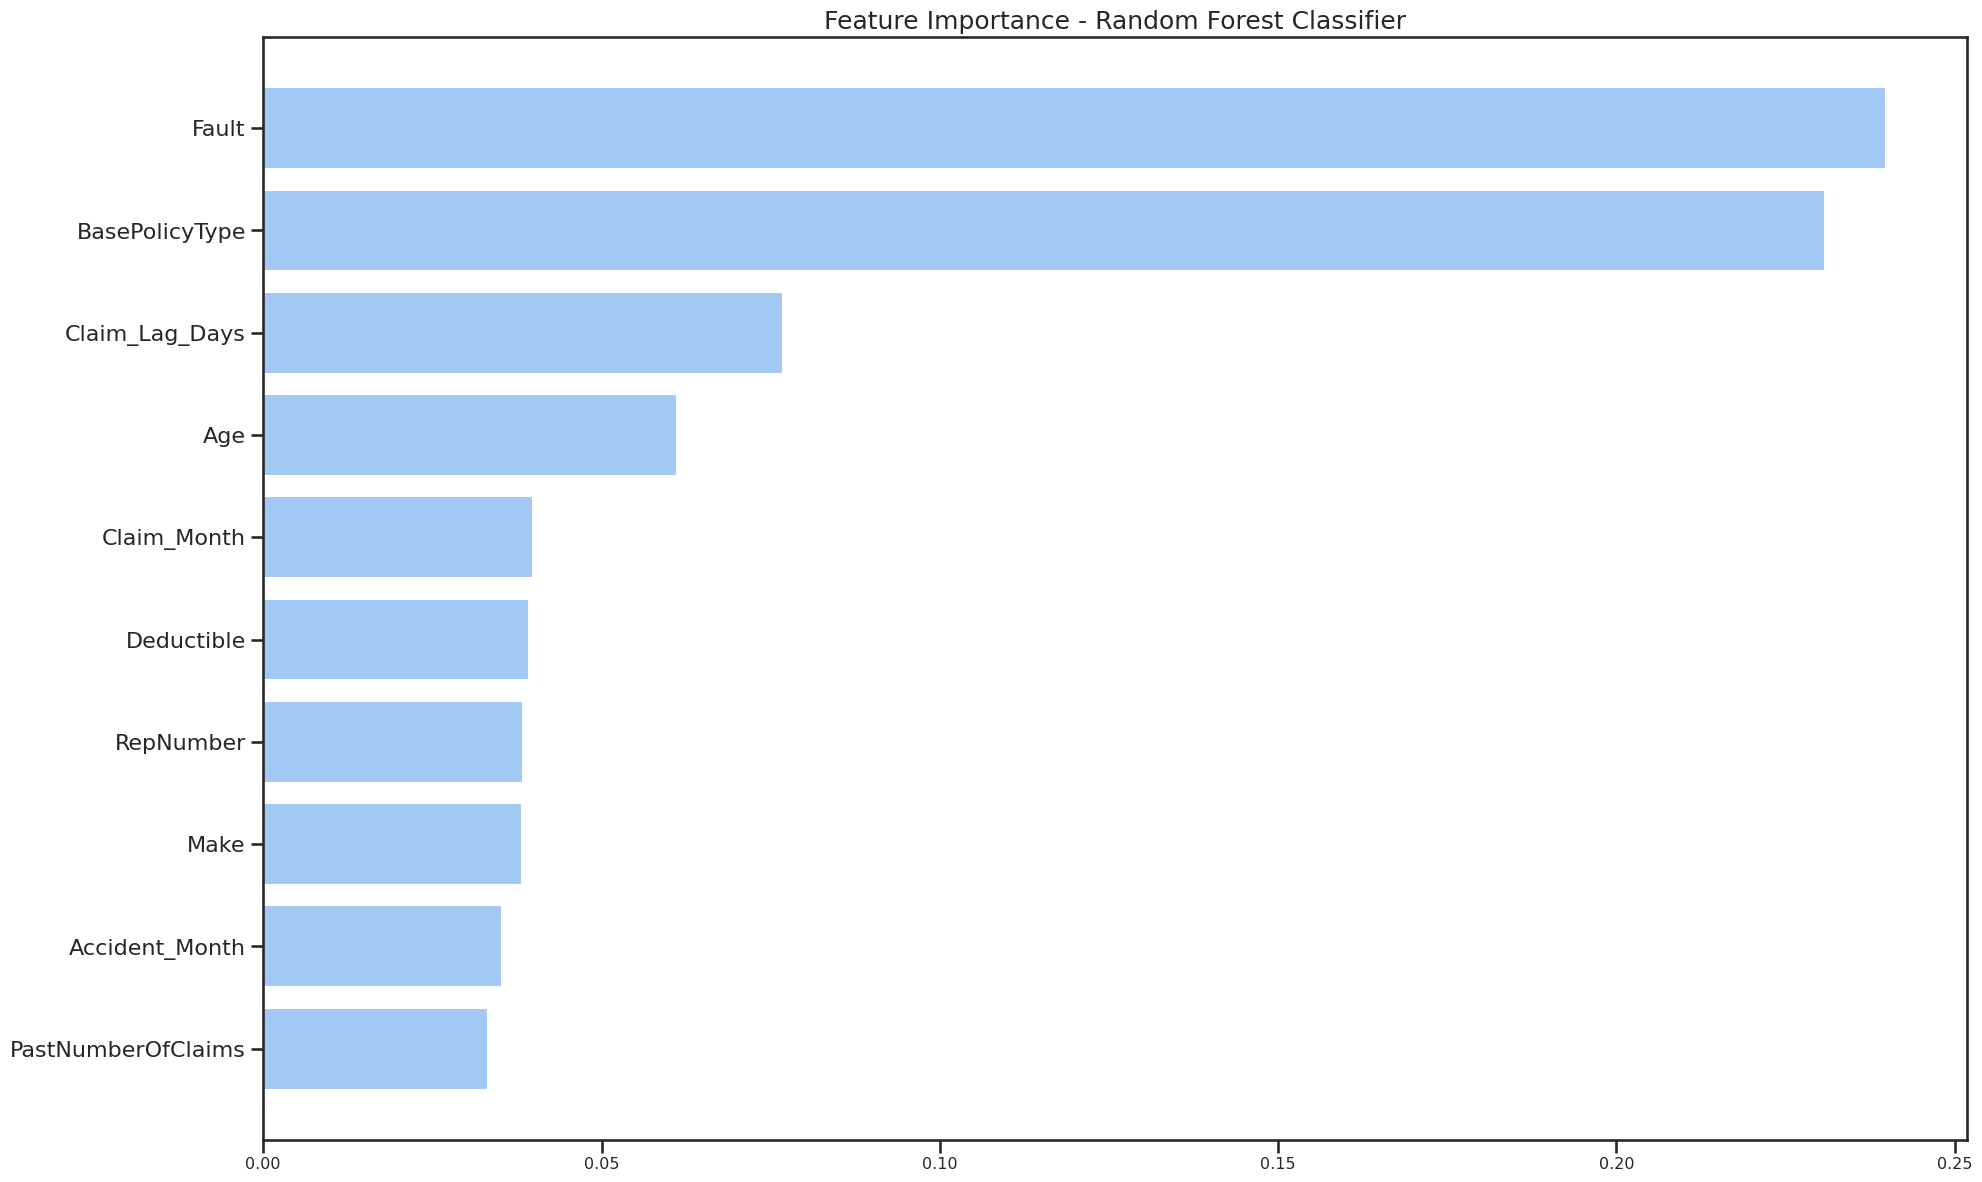

In [ ]:
# Display feature importance
importances = randomforest.feature_importances_
features = X_train.columns

indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

plt.figure(figsize=(20,12))
plt.title("Feature Importance - Random Forest Classifier", fontsize=18)
plt.barh(range(10), importances[indices][:10][::-1])
plt.yticks(range(10), [names[i] for i in range(9, -1, -1)], fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Create a list of tuples containing the feature names and importance scores
feature_importances = list(zip(features, importances))

# Sort the feature_importances list by importance scores in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance Random Forest Classifier")
# Print the features and their importance scores
for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature Importance Random Forest Classifier
Feature: Fault, Importance: 0.23977804260848712
Feature: BasePolicyType, Importance: 0.23088670180835427
Feature: Claim_Lag_Days, Importance: 0.07686649004818748
Feature: Age, Importance: 0.06122103009211733
Feature: Claim_Month, Importance: 0.039880761966270446
Feature: Deductible, Importance: 0.03922749115812915
Feature: RepNumber, Importance: 0.038433435928587514
Feature: Make, Importance: 0.03831695442410825
Feature: Accident_Month, Importance: 0.03532790246659444
Feature: PastNumberOfClaims, Importance: 0.03314758490302346
Feature: AddressChange_Claim, Importance: 0.031328811283515653
Feature: VehiclePrice, Importance: 0.027657781584612844
Feature: AgeOfVehicle, Importance: 0.022003584977192445
Feature: NumberOfSuppliments, Importance: 0.02162312743153964
Feature: DriverRating, Importance: 0.01961264306724593
Feature: MaritalStatus, Importance: 0.008374137678135322
Feature: Sex, Importance: 0.007151087858467889
Feature: AccidentArea, Imp

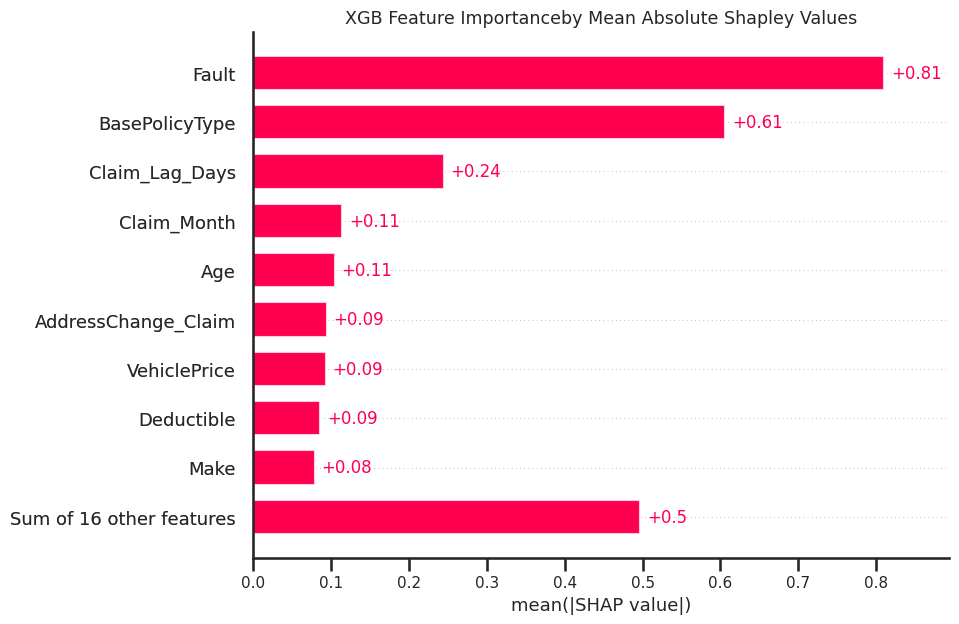

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_test)

# Summary Plot
plt.title("XGB Feature Importanceby Mean Absolute Shapley Values")
shap.plots.bar(shap_values) 

In [ ]:
import graphviz
import re
from sklearn.tree import export_graphviz

target_names = ["Non-Fraud", "Fraud"]

# Select one tree from the forest for visualization
chosen_tree = randomforest.estimators_[5]

dot_data = export_graphviz(chosen_tree, 
                           feature_names=features,
                           class_names=target_names, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph.render('rf_tree')

'rf_tree.png'

# Assessing Financial Impact

According to the Insurance Information Institute (III), the average claim severity for collision and comprehensive auto insurance losses from 2019 to 2021 was approximately **$6,000**. By considering this average loss amount, we can project the potential impact of fraud reduction measures on overall savings. Implementing effective fraud detection and prevention strategies can aid insurance companies in mitigating losses tied to fraudulent claims, leading to substantial cost savings and enhanced operational efficiency.

Please note that the original dataset used for this analysis did not provide specific details regarding actual claim amounts or insurance losses.

Source: https://www.iii.org/table-archive/21040

In [ ]:
# Calculate total fraudulent cases and total cases for each date
fraud_cases_by_date = df.groupby('Accident_Date')['FraudFound_P'].sum().reset_index()
total_cases_by_date = df.groupby('Accident_Date')['FraudFound_P'].count().reset_index()

fraud_loss = pd.merge(fraud_cases_by_date, total_cases_by_date, on='Accident_Date')
fraud_loss.columns = ['Accident_Date', 'Total_Fraudulent_Cases', 'Total_Cases']

avg_auto_insurance_loss = 6000
fraud_loss['Approx_Loss'] = fraud_loss['Total_Fraudulent_Cases'] * avg_auto_insurance_loss

In [ ]:
from prophet import Prophet

# Prepare the data for Prophet
forecast_data = fraud_loss[['Accident_Date', 'Approx_Loss']]
forecast_data.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(forecast_data)

# Generate future dates for forecasting
future_dates = model.make_future_dataframe(periods=365)

# Make the forecast
forecast = model.predict(future_dates)

# Print the forecasted values for the next 365 days
forecast_next_365_days = forecast.tail(365)[['ds', 'yhat']]
print(forecast_next_365_days)


05:17:56 - cmdstanpy - INFO - Chain [1] start processing
05:17:57 - cmdstanpy - INFO - Chain [1] done processing
             ds         yhat
1034 2021-12-29  4614.017892
1035 2021-12-30  6519.231564
1036 2021-12-31  5035.465461
1037 2022-01-01  4409.941676
1038 2022-01-02  5241.666468
...         ...          ...
1394 2022-12-24  4576.068371
1395 2022-12-25  5490.380539
1396 2022-12-26  5750.520412
1397 2022-12-27  5090.576656
1398 2022-12-28  4966.027930

[365 rows x 2 columns]


In [ ]:
# Calculate the reduced losses by 80%
reduced_losses_80 = forecast_next_365_days.copy()
reduced_losses_80['yhat_reduced_80'] = reduced_losses_80['yhat'] * 0.2

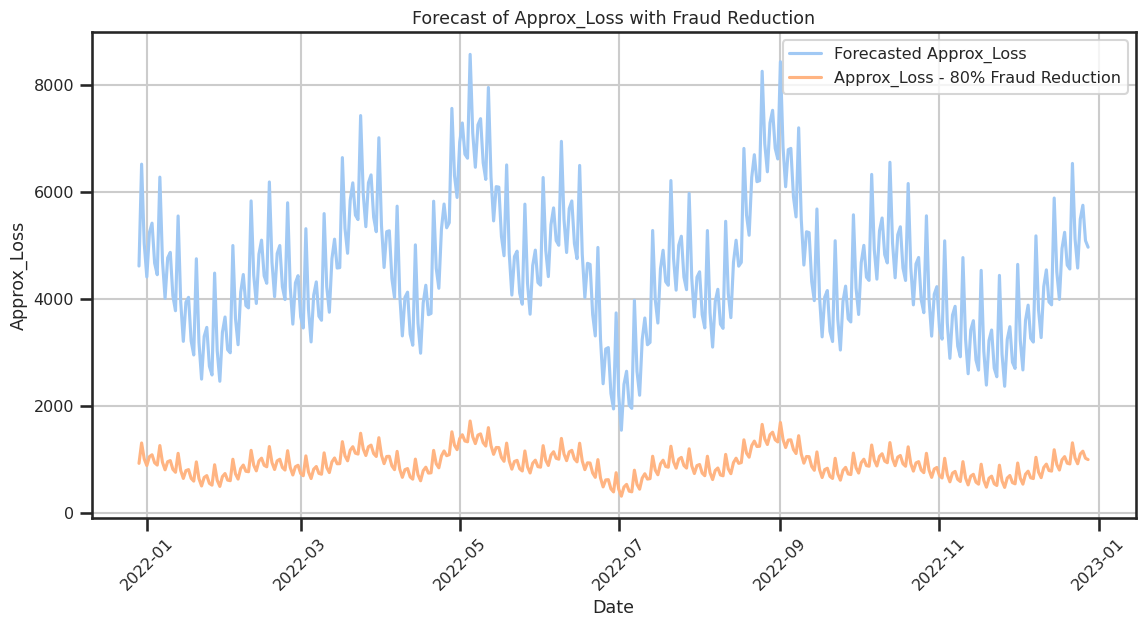

In [ ]:
# Plot the forecasted values with fraud reduction by 80%
plt.figure(figsize=(12, 6))
plt.plot(forecast_next_365_days['ds'], forecast_next_365_days['yhat'], label='Forecasted Approx_Loss')
plt.plot(reduced_losses_80['ds'], reduced_losses_80['yhat_reduced_80'], label='Approx_Loss - 80% Fraud Reduction')
plt.xlabel('Date')
plt.ylabel('Approx_Loss')
plt.title('Forecast of Approx_Loss with Fraud Reduction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate the savings for 80% fraud reduction
savings_80 = forecast_next_365_days['yhat'] - reduced_losses_80['yhat_reduced_80']

# Create a new dataframe to store the savings
savings_df = forecast_next_365_days[['ds']].copy()
savings_df['Savings_80'] = savings_80

# Calculate the total savings for 80% fraud reduction
total_savings_80 = round(savings_80.sum(), -4)

# Print the total savings
print("Total Savings for 80% Fraud Reduction:", total_savings_80)

Total Savings for 80% Fraud Reduction: 1340000.0


Based on the analysis conducted using forecasted values and assuming the implementation of a Random Forest fraud detection model, we can estimate the potential savings for the business by reducing future fraudulent claims by 80%.

Achieving an 80% reduction in fraud with the aid of the Random Forest fraud detection model, the forecast suggests that total savings could amount to a considerable **$1,340,000** over the next year.

These estimates underscore the significant influence that the deployment of an effective fraud detection model can have in curtailing losses associated with fraudulent claims. By leveraging data analysis and machine learning techniques, businesses can potentially save significant amounts of money by identifying and preventing fraudulent activities within their insurance claim processes.

# Conclusion and Next Steps

This study has demonstrated the potential of machine learning, specifically the Random Forest Classifier, in identifying fraudulent vehicle insurance claims. The model's performance, as indicated by its high F1-score and ROC-AUC score, suggests that it can effectively differentiate between fraudulent and non-fraudulent claims. This capability can lead to substantial cost savings for the insurance company and contribute to improved operational efficiency.

However, the journey does not end here. The following are potential next steps to further enhance the effectiveness of our fraud detection system:

**1. Data Requirements**

The current study is only based on three years of data. Extending the time period of data collection could provide a more comprehensive view of fraud trends and patterns. Additionally, collecting more detailed information is recommended. Key data points include:

- **Claim History:** Past claims made by the insured, such as the number, frequency, type, and size of claims. Higher than average claims may be a red flag for fraud.

- **Policy Details:** Aspects like policy age, premium payment history, and any recent policy changes. For example, a large claim soon after increasing coverage might be suspicious.

- **Claim Details:** Circumstances of the claim, like time and location of the incident and who reported it. Certain patterns like claims made shortly after policy inception may raise suspicion.

**2. Model Improvement**

While the Random Forest Classifier has shown promising results, there is always room for improvement. We can explore other machine learning algorithms or ensemble methods to see if they yield better results. Additionally, more advanced techniques such as deep learning could be explored for this task.

**3. Handling Imbalanced Data**

The dataset used in this study was imbalanced, which is a common issue in fraud detection. We can explore different techniques for handling imbalanced data, such as SMOTE or ADASYN, to improve the model's performance.

**4. Real-time Fraud Detection**

Once the model is optimized, we can implement it into a real-time fraud detection system. This would allow insurance companies to detect fraudulent claims as soon as they are made, significantly reducing the potential for financial loss.

By pursuing these next steps, we can continue to improve the accuracy and efficiency of our fraud detection system, providing significant benefits to the insurance industry.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39ff504f-0c4f-4bcb-9b0d-eb99ef4b289f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>